# Exploration of new techniques to build a connectome
The aim of this notebook is to test various ideas to try to avoid the construction of a differential network.

#### Data importation

In [1]:
import pandas as pd
import numpy as np
import random
import warnings

from scipy.linalg import eigvalsh
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

from utilsData import load_data_from_patients_folder, add_mean_SUV_index
from utilsStats import build_correlation_matrix, build_graph_from_correlation_df, build_significance_matrix_for_diff, is_connected
from utilsVisual import plot_correlogram, plot_connectome
from utilsClustering import custom_spectral_clustering_on_similarity_matrix, compute_frobenius_similarity, compute_cosine_similarity, compute_spectral_distance, compute_deltaCon_distance, compute_cut_distance, compute_mahalanobis_similarity
from utilsExploration import *

random.seed(2003)
np.random.seed(2003) 

In [2]:

patients_data = load_data_from_patients_folder("../Data/PATIENTS")
patients_data = add_mean_SUV_index(patients_data)

controls_data = load_data_from_patients_folder("../Data/CONTROLES")
controls_data = add_mean_SUV_index(controls_data)

patients = patients_data.keys()
controls = controls_data.keys()

patients_list = list(patients)
controls_list = list(controls)

names = patients_data[list(patients)[0]].loc["name"]
names = names.to_numpy()

print(f"Loaded data for {len(patients_data)}-{len(controls_data)} patients.")

Loaded data for 27-53 patients.


#### Exploration of the data

In [ ]:
normal_group = [patients_data[item].loc["mean_SUV"].to_numpy() for item in patients_list]

In [ ]:
import numpy as np
from scipy.stats import entropy
from scipy.stats import ttest_ind

def js_divergence(p, q):
    p = np.asarray(p, dtype=np.float64)
    q = np.asarray(q, dtype=np.float64)
    m = 0.5 * (p + q)
    return 0.5 * (entropy(p, m) + entropy(q, m))

# Example usage
normal_group = [patients_data[item].loc["mean_SUV"].to_numpy() / max(patients_data[item].loc["mean_SUV"].to_numpy()) for item in patients_list]
new_dist = controls_data[controls_list[0]].loc["mean_SUV"].to_numpy() / max(controls_data[controls_list[0]].loc["mean_SUV"].to_numpy())

jsds = [js_divergence(new_dist, d) for d in normal_group]
average_jsd = np.mean(jsds)
print(f"Average JS Divergence: {average_jsd}")
print("------")
patients_div = []
for item in patients_list:
    jsds = [js_divergence(patients_data[item].loc["mean_SUV"].to_numpy()/max(patients_data[item].loc["mean_SUV"].to_numpy()), d) for d in normal_group]
    average_jsd = np.mean(jsds)
    #print(f"Average JS Divergence: {average_jsd}")
    patients_div.append(average_jsd)
print("------")
controls_div = []
for item in controls_list:
    jsds = [js_divergence(controls_data[item].loc["mean_SUV"].to_numpy()/max(controls_data[item].loc["mean_SUV"].to_numpy()), d) for d in normal_group]
    average_jsd = np.mean(jsds)
    controls_div.append(average_jsd)
    #print(f"Average JS Divergence: {average_jsd}")

print(np.mean(patients_div), np.mean(controls_div))
print(np.var(patients_div), np.var(controls_div))


# Perform an independent t-test
t_stat, p_value = ttest_ind(patients_div, controls_div, equal_var=False)  # Welch's t-test

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05  # Common significance level
if p_value < alpha:
    print("There is a statistically significant difference between patients and controls (p < 0.05).")
else:
    print("No statistically significant difference found (p >= 0.05).")


In [ ]:
plot_distribution_vector([patients_data[item][10]["SUV"]/max(patients_data[item][10]["SUV"]) for item in patients_list])

In [ ]:
plot_distribution_vector([controls_data[item][10]["SUV"]/max(controls_data[item][10]["SUV"]) for item in controls_list])

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def check_distribution_type_with_tail_removal(vector_of_distributions, alpha=0.05):
    """
    Checks distribution types, first with original data, then after removing the top 5% of values.

    Args:
        vector_of_distributions: A list of lists or numpy arrays.
        alpha: Significance level for tests.

    Returns:
        A tuple of two lists: original results and results after tail removal.
    """

    original_results = []
    tail_removed_results = []

    for i, distribution in enumerate(vector_of_distributions):
        distribution = np.array(distribution)

        # Original data tests
        original_result = perform_distribution_tests(distribution, alpha, i, "Original")
        original_results.append(original_result)

        # Remove top 5% and perform tests again
        threshold = np.percentile(distribution, (1-alpha)*100)
        trimmed_distribution = distribution[distribution <= threshold]

        tail_removed_result = perform_distribution_tests(trimmed_distribution, alpha, i, "Tail Removed")
        tail_removed_results.append(tail_removed_result)

    return original_results, tail_removed_results

def perform_distribution_tests(distribution, alpha, index, data_label):
    """
    Performs the distribution tests and generates Q-Q plots.
    """
    shapiro_stat, shapiro_p = stats.shapiro(distribution)
    ks_lognorm_stat, ks_lognorm_p = stats.kstest(distribution, 'lognorm', args=(np.mean(np.log(distribution)), np.std(np.log(distribution))))

    try:
        params = stats.gamma.fit(distribution, floc=0)
        ks_gamma_stat, ks_gamma_p = stats.kstest(distribution, 'gamma', args=params)
    except (ValueError, ZeroDivisionError) as e:
        print(f"Warning: Gamma fit failed for distribution {index} ({data_label}): {e}")
        ks_gamma_stat, ks_gamma_p = np.nan, np.nan

    result = {
        "distribution_index": index,
        "shapiro_stat": shapiro_stat,
        "shapiro_p": shapiro_p,
        "normal": shapiro_p > alpha,
        "ks_lognorm_stat": ks_lognorm_stat,
        "ks_lognorm_p": ks_lognorm_p,
        "lognormal": ks_lognorm_p > alpha,
        "ks_gamma_stat": ks_gamma_stat,
        "ks_gamma_p": ks_gamma_p,
        "gamma": ks_gamma_p > alpha if not np.isnan(ks_gamma_p) else False,
        "data_label" : data_label
    }

    # QQ plots
    plt.figure(figsize=(15, 3))

    plt.subplot(1, 3, 1)
    stats.probplot(distribution, dist="norm", plot=plt)
    plt.title(f"Distribution {index} ({data_label}) - Normal Q-Q Plot")

    plt.subplot(1, 3, 2)
    stats.probplot(distribution, dist=stats.lognorm(s=np.std(np.log(distribution)), scale=np.exp(np.mean(np.log(distribution)))), plot=plt)
    plt.title(f"Distribution {index} ({data_label}) - Log-Normal Q-Q Plot")

    plt.subplot(1, 3, 3)
    if not np.isnan(ks_gamma_p):
        stats.probplot(distribution, dist=stats.gamma(a=params[0], loc=params[1], scale=params[2]), plot=plt)
        plt.title(f"Distribution {index} ({data_label}) - Gamma Q-Q Plot")
    else:
        plt.text(0.5, 0.5, "Gamma fit failed", ha='center', va='center')

    plt.tight_layout()
    #plt.show()

    return result

In [ ]:

#results = check_distribution_type([np.exp(controls_data[item][10]["SUV"]) for item in controls_list])
#for result in results:
#    print(f"Distribution {result['distribution_index']}:")
#    print(f"  Normal: {result['normal']} (Shapiro-Wilk p-value: {result['shapiro_p']})")
#    print(f"  Lognormal: {result['lognormal']} (KS p-value: {result['ks_lognorm_p']})")
#    print(f"  Gamma: {result['gamma']} (KS p-value: {result['ks_gamma_p']})")
#    print("-" * 20)

original_results, tail_removed_results = check_distribution_type_with_tail_removal([controls_data[item][10]["SUV"] for item in controls_list], alpha=0.01)

print("Original Data Results:")
for result in original_results:
    print(f"Distribution {result['distribution_index']} ({result['data_label']}):")
    print(f"  Normal: {result['normal']} (Shapiro-Wilk p-value: {result['shapiro_p']})")
    print(f"  Lognormal: {result['lognormal']} (KS p-value: {result['ks_lognorm_p']})")
    print(f"  Gamma: {result['gamma']} (KS p-value: {result['ks_gamma_p']})")
    print("-" * 20)

print("\nTail Removed Results:")
for result in tail_removed_results:
    print(f"Distribution {result['distribution_index']} ({result['data_label']}):")
    print(f"  Normal: {result['normal']} (Shapiro-Wilk p-value: {result['shapiro_p']})")
    print(f"  Lognormal: {result['lognormal']} (KS p-value: {result['ks_lognorm_p']})")
    print(f"  Gamma: {result['gamma']} (KS p-value: {result['ks_gamma_p']})")
    print("-" * 20)

In [ ]:
patients_data[patients_list[0]].loc["SUV"]

In [ ]:
[patients_data[item][10]["SUV"]/max(patients_data[item][10]["SUV"]) for item in patients_list]

### Experiment A: Let's build individual connectomes

In [ ]:
import numpy as np

def build_adjacency_matrix(organs, metric="kl_divergence", threshold=None, k=None):
    """
    Build the adjacency matrix for a graph of organs based on log-normal distribution parameters.

    Parameters:
        organs (dict): Dictionary where keys are organ names and values are (mean, variance) tuples.
        metric (str): Distance metric to use ("kl_divergence", "euclidean-on-log", "bhattacharyya").
        threshold (float, optional): Maximum allowed distance to connect nodes (used for threshold-based graphs).
        k (int, optional): Number of nearest neighbors to connect each node (used for k-NN graphs).

    Returns:
        np.ndarray: Adjacency matrix (symmetric).
        list: Ordered list of organ names corresponding to matrix indices.
    """
    organ_names = list(organs.keys())
    num_organs = len(organ_names)
    
    # Convert organ dictionary to a NumPy array for easier computation
    organ_vectors = np.array([organs[name] for name in organ_names])
    
    # Convert (mean, variance) to underlying normal parameters (mu, sigma²)
    log_mu = np.log(organ_vectors[:, 0]**2 / np.sqrt(organ_vectors[:, 1] + organ_vectors[:, 0]**2))
    log_sigma_sq = np.log(organ_vectors[:, 1] / organ_vectors[:, 0]**2 + 1)

    # Compute pairwise distances
    distance_matrix = np.zeros((num_organs, num_organs))

    if metric == "kl_divergence":
        def kl_divergence(i, j):
            mu1, sigma1_sq = log_mu[i], log_sigma_sq[i]
            mu2, sigma2_sq = log_mu[j], log_sigma_sq[j]
            return 0.5 * (sigma2_sq / sigma1_sq + (mu1 - mu2)**2 / sigma1_sq - 1 + np.log(sigma1_sq / sigma2_sq))

        for i in range(num_organs):
            for j in range(i + 1, num_organs):
                dist = kl_divergence(i, j) + kl_divergence(j, i)  # Symmetric KL divergence
                distance_matrix[i, j] = dist
                distance_matrix[j, i] = dist  # Ensure symmetry

    elif metric == "euclidean-on-log":
        # Compute Euclidean distance between (log_mu, log_sigma_sq) representations
        log_vectors = np.vstack((log_mu, log_sigma_sq)).T
        for i in range(num_organs):
            for j in range(i + 1, num_organs):
                dist = np.linalg.norm(log_vectors[i] - log_vectors[j])
                distance_matrix[i, j] = dist
                distance_matrix[j, i] = dist  # Ensure symmetry

    elif metric == "bhattacharyya":
        def bhattacharyya(i, j):
            mu1, sigma1_sq = log_mu[i], log_sigma_sq[i]
            mu2, sigma2_sq = log_mu[j], log_sigma_sq[j]
            return 0.25 * np.log(0.25 * (sigma1_sq / sigma2_sq + sigma2_sq / sigma1_sq + 2)) + \
                   0.25 * ((mu1 - mu2)**2 / (sigma1_sq + sigma2_sq))

        for i in range(num_organs):
            for j in range(i + 1, num_organs):
                dist = bhattacharyya(i, j)
                distance_matrix[i, j] = dist
                distance_matrix[j, i] = dist  # Ensure symmetry

    else:
        raise ValueError("Unsupported metric. Choose 'kl_divergence', 'euclidean-on-log', or 'bhattacharyya'.")

    # Build adjacency matrix based on threshold or k-NN
    adjacency_matrix = np.zeros((num_organs, num_organs))

    if threshold is not None:
        if threshold != 0:
            adjacency_matrix[distance_matrix < threshold] = 1
        else:    
            adjacency_matrix = np.max(distance_matrix) - distance_matrix

    elif k is not None:
        for i in range(num_organs):
            nearest_indices = np.argsort(distance_matrix[i])[1:k+1]  # Exclude self (index 0)
            adjacency_matrix[i, nearest_indices] = 1
            adjacency_matrix[nearest_indices, i] = 1  # Ensure symmetry

    np.fill_diagonal(adjacency_matrix, 0)  # No self-loops

    return adjacency_matrix, organ_names


In [40]:
patients_connectomes = {}
controls_connectomes = {}

for patient in patients_list:
    organs_raw = patients_data[patient].loc["SUV"].to_numpy()
    organs = build_organ_dict(organs_raw)
    adj_matrix, organ_names = build_adjacency_matrix(organs, metric="bhattacharyya", threshold=0)
    adj_matrix2, organ_names2 = build_adjacency_matrix(organs, metric="kl_divergence", threshold=0)
    adj_matrix3, organ_names3 = build_adjacency_matrix(organs, metric="euclidean-on-log", threshold=0)
    patients_connectomes[patient] = {'bhattacharyya': normalize_matrix_no_diagonal(adj_matrix), 
                                     'kl_divergence': normalize_matrix_no_diagonal(adj_matrix2), 
                                     'euclidean-on-log': normalize_matrix_no_diagonal(adj_matrix3), 
                                     'organs': organs}

for patient in controls_list:
    organs_raw = controls_data[patient].loc["SUV"].to_numpy()
    organs = build_organ_dict(organs_raw)
    adj_matrix, organ_names = build_adjacency_matrix(organs, metric="bhattacharyya", threshold=0)
    adj_matrix2, organ_names2 = build_adjacency_matrix(organs, metric="kl_divergence", threshold=0)
    adj_matrix3, organ_names3 = build_adjacency_matrix(organs, metric="euclidean-on-log", threshold=0)
    controls_connectomes[patient] = {'bhattacharyya': normalize_matrix_no_diagonal(adj_matrix), 
                                     'kl_divergence': normalize_matrix_no_diagonal(adj_matrix2), 
                                     'euclidean-on-log': normalize_matrix_no_diagonal(adj_matrix3), 
                                     'organs': organs}


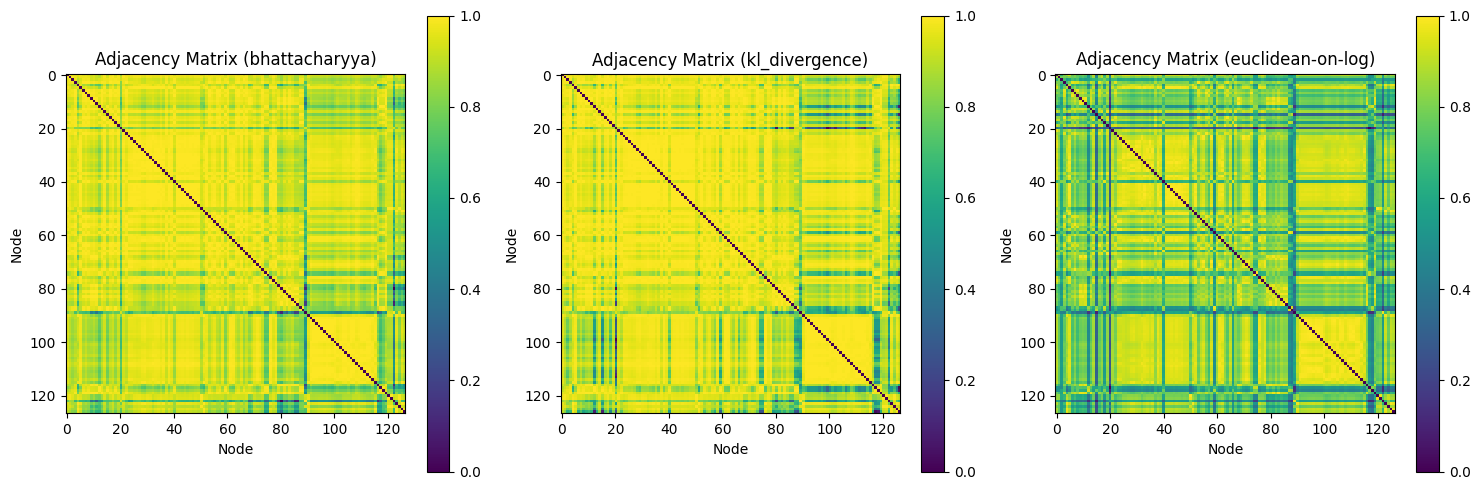

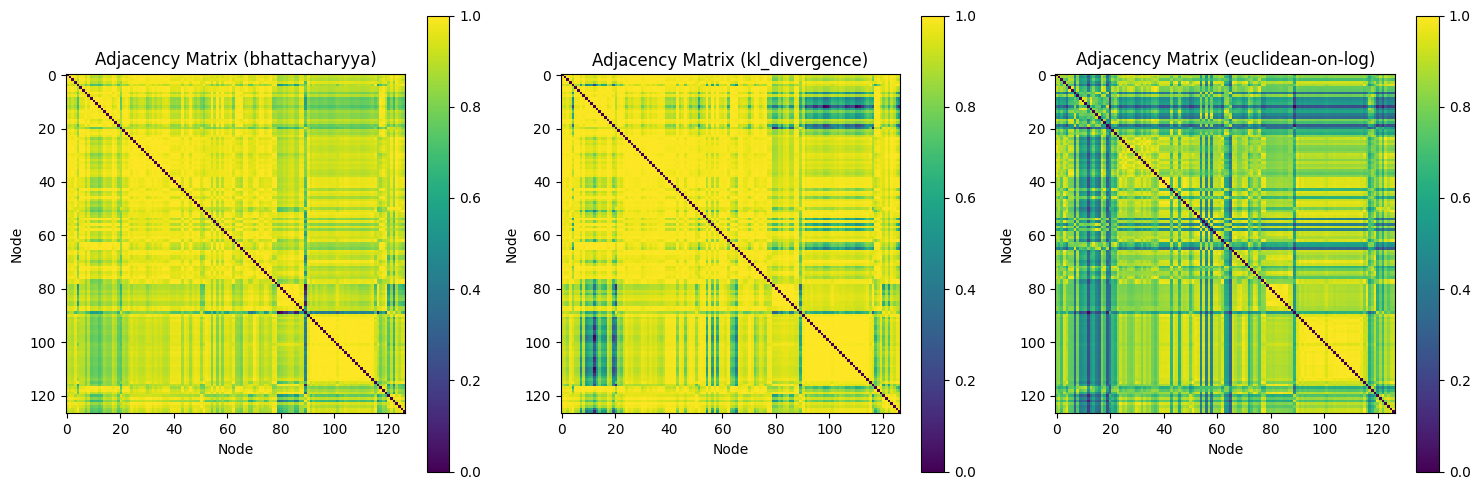

In [42]:
print_adjacency_matrices(patients_connectomes[patients_list[0]])

print_adjacency_matrices(controls_connectomes[controls_list[0]])

##### Now that we do have our individual connectomes, we try direct clustering...
...but it's a fail

Cluster labels: [1 0 0 0 0 0 0 1 1 1 0 1 1 1 0 1 0 0 0 0 0 1 1 1 1 0 1 1 0 0 1 0 1 0 0 0 1
 1 0 0 1 0 0 0 0 1 0 1 1 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 1 1 0 0 1 0]
Cluster labels (after PCA): [0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0
 0 1 1 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 1 1 1 1 0
 0 0 1 1 0 1]


/var/folders/qc/fbm2wz190nqd87d2mq7l90_80000gn/T/ipykernel_51024/3823648196.py:4: UserWarning: The adjacency matrix is not associated with a fully connected graph.
  warnings.warn("The adjacency matrix is not associated with a fully connected graph.")


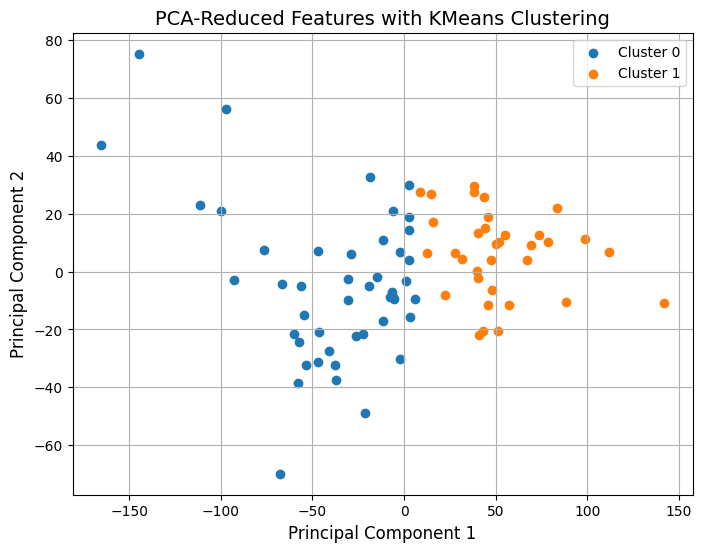

In [57]:
# Compute spectral features (e.g., eigenvalues of the graph Laplacian)
def compute_spectral_features(adj_matrix):
    if is_connected(adj_matrix) is not True:
        warnings.warn("The adjacency matrix is not associated with a fully connected graph.")
    degree_matrix = np.diag(adj_matrix.sum(axis=1))
    laplacian = degree_matrix - adj_matrix
    eigenvalues = eigvalsh(laplacian)
    return eigenvalues
    
features = [
    compute_spectral_features(
        #np.where(np.abs(test_correlation_matrices[patient_matrices]["z_matrix"].to_numpy()) < 0.3, 0, 
        #         test_correlation_matrices[patient_matrices]["z_matrix"].to_numpy())
        patient_matrices['euclidean-on-log']
    )
    for patient_matrices in (patients_connectomes | controls_connectomes).values()
]

# Perform clustering
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(features)

print("Cluster labels:", labels)

# Reduce dimensions (optional)
from sklearn.decomposition import PCA
features_reduced = PCA(n_components=2).fit_transform(features)

# Perform clustering
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(features_reduced)

print("Cluster labels (after PCA):", labels)

plt.figure(figsize=(8, 6))
for label in np.unique(labels):
    plt.scatter(
        features_reduced[labels == label, 0],  # x-coordinates for the cluster
        features_reduced[labels == label, 1],  # y-coordinates for the cluster
        label=f"Cluster {label}"
    )

# Add labels and legend
plt.title("PCA-Reduced Features with KMeans Clustering", fontsize=14)
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Clusters are not separated...

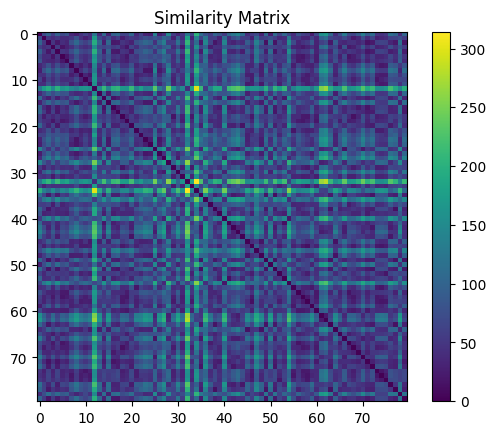

Cluster labels: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0]


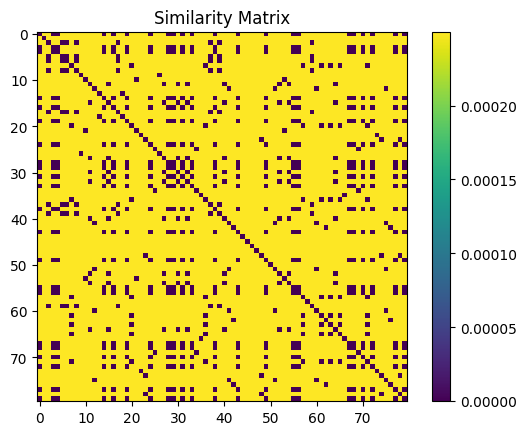

Cluster labels: [0 0 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1
 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 1 1 1 0 0 1 1
 0 0 0 0 0 0]


In [62]:
adj_matrices = [
    patient_matrices['euclidean-on-log']
    for patient_matrices in (patients_connectomes | controls_connectomes).values()
]
for adj in adj_matrices:
    np.fill_diagonal(adj, 0)  # Remove self-loops

print("Cluster labels:", custom_spectral_clustering_on_similarity_matrix(compute_spectral_distance(adj_matrices)))

print("Cluster labels:", custom_spectral_clustering_on_similarity_matrix(compute_cut_distance(adj_matrices)))

##### Let's try to build a reference matrix


In [ ]:
reference_matrix = np.mean([
    patient_matrices['kl_divergence']
    for patient_matrices in patients_connectomes.values()
])
distance_to_ref_patients = [
    (reference_matrix - patient_matrices['kl_divergence'])
    for patient_matrices in (patients_connectomes).values()]

distance_to_ref_controls = [
    (reference_matrix - patient_matrices['kl_divergence'])
    for patient_matrices in (controls_connectomes).values()]

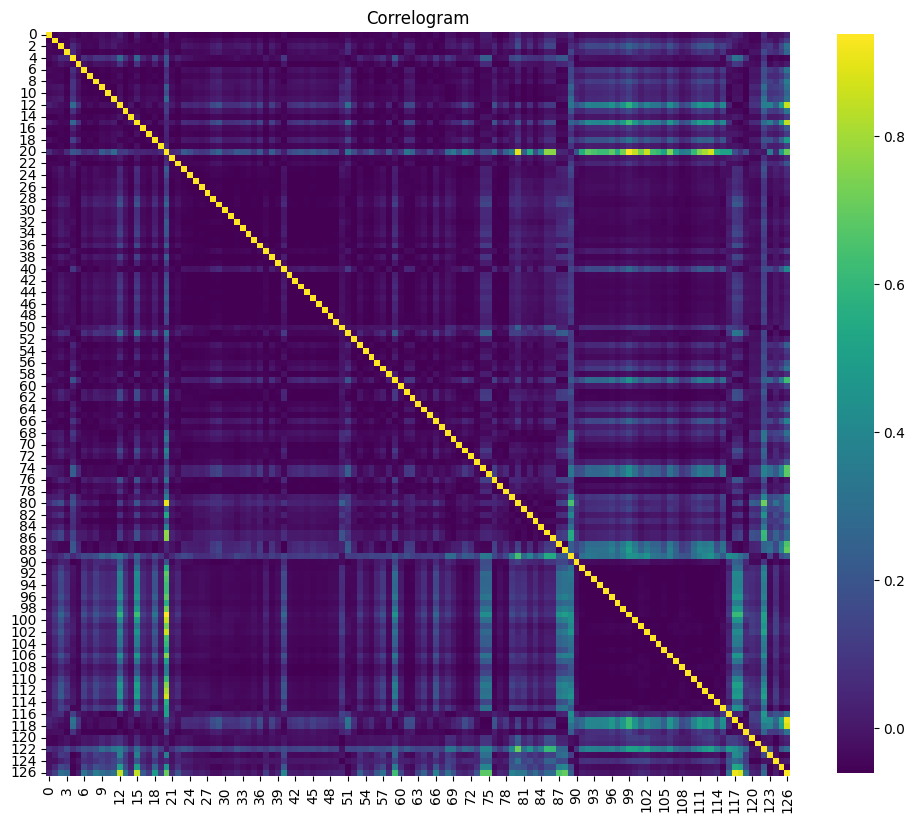

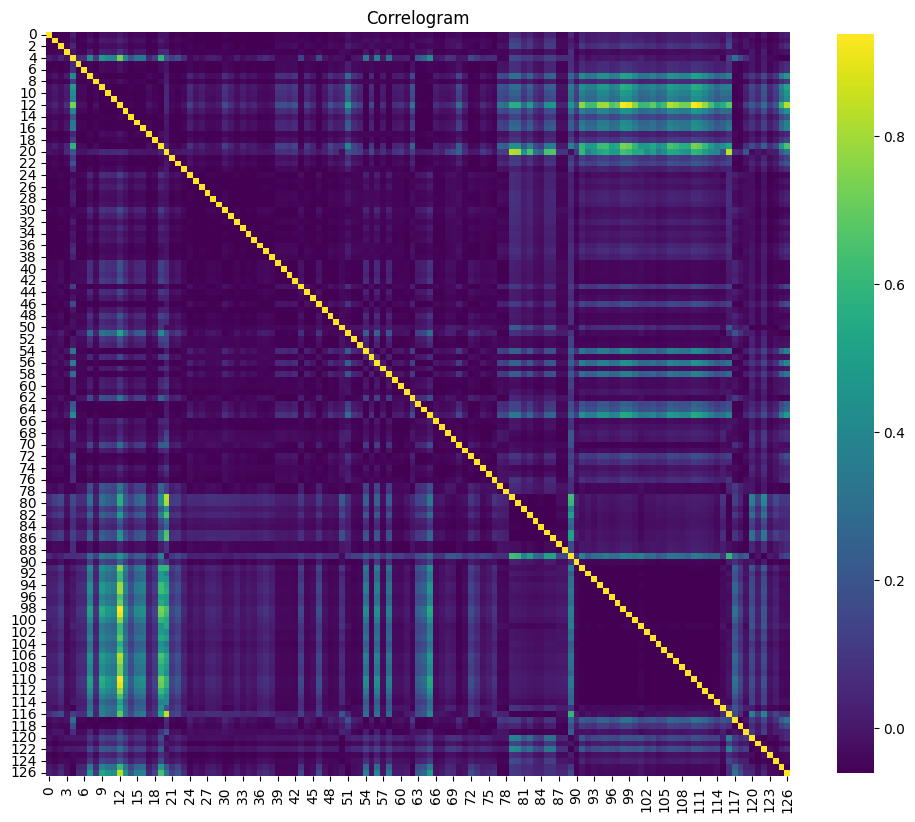

In [127]:
plot_correlogram(distance_to_ref_patients[0])
plot_correlogram(distance_to_ref_controls[0])

In [ ]:
print(np.mean(np.mean(distance_to_ref_patients, axis=1), axis=1), np.mean(np.mean(np.mean(distance_to_ref_patients, axis=1), axis=1)))
print(np.mean(np.mean(distance_to_ref_controls, axis=1), axis=1), np.mean(np.mean(np.mean(distance_to_ref_controls, axis=1), axis=1)))

(27, 127, 127)
[ 0.02053262 -0.00554268 -0.01548013 -0.01354434 -0.01411766 -0.01733902
  0.00932745 -0.00051216  0.01682635 -0.0033945   0.0076931   0.00636443
  0.01498859  0.0291586  -0.0094977   0.02299417 -0.01231547 -0.00950938
 -0.00932727 -0.00677125 -0.02184067  0.00528178 -0.00087486  0.02990466
 -0.01289039 -0.02344222  0.01332795] -8.4872952287606e-17
[ 0.02698356 -0.02609408 -0.00739107  0.02327745 -0.00850154  0.03405147
 -0.00572983 -0.03233871 -0.01934425  0.00162109  0.01685674 -0.02391022
 -0.00062147  0.02967315 -0.01353755 -0.02111855 -0.0253124  -0.02773352
 -0.00550102  0.00012054  0.00727115  0.01108785 -0.02920634  0.0210887
 -0.01584018  0.01936416 -0.01093599  0.02598075  0.02028159 -0.00750077
 -0.01576888  0.01464872  0.01138721 -0.0170727  -0.02756647 -0.02630463
 -0.01247828  0.01502926 -0.02440453 -0.023107   -0.00886105 -0.02097842
 -0.01330129 -0.0171856  -0.01142763 -0.01767104  0.01814986  0.01345263
 -0.00899845 -0.00786394 -0.02746643  0.01063239 -0

In [175]:
print(np.var(distance_to_ref_patients))
print(np.mean(distance_to_ref_patients))
print(np.mean(np.sum(np.sum(distance_to_ref_patients, axis=1), axis=1)))
print(np.var(distance_to_ref_controls))
print(np.mean(distance_to_ref_controls))
print(np.mean(np.sum(np.sum(distance_to_ref_controls, axis=1), axis=1)))

0.014945452886547417
-8.481160321943683e-17
-1.3684526762787114e-12
0.014524720221458828
-0.004686504346248813
-75.58862860064713


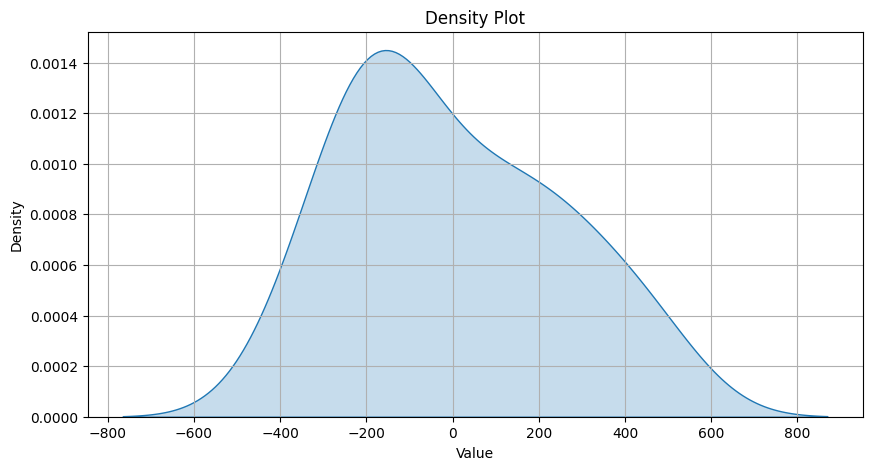

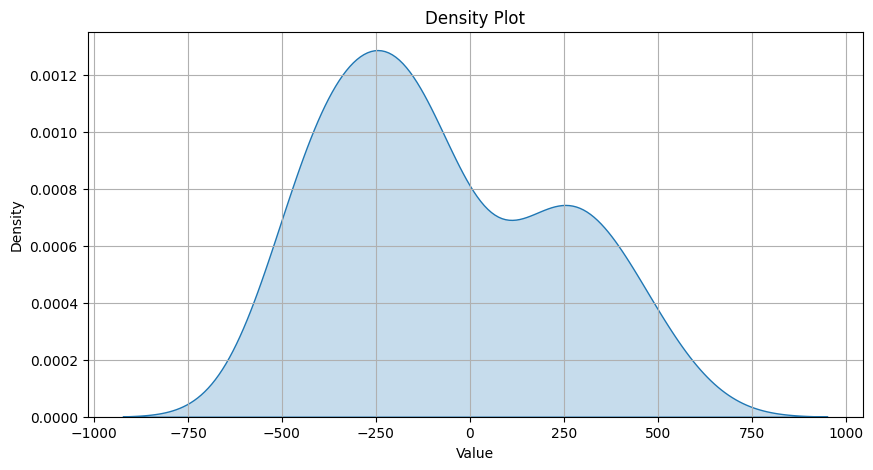

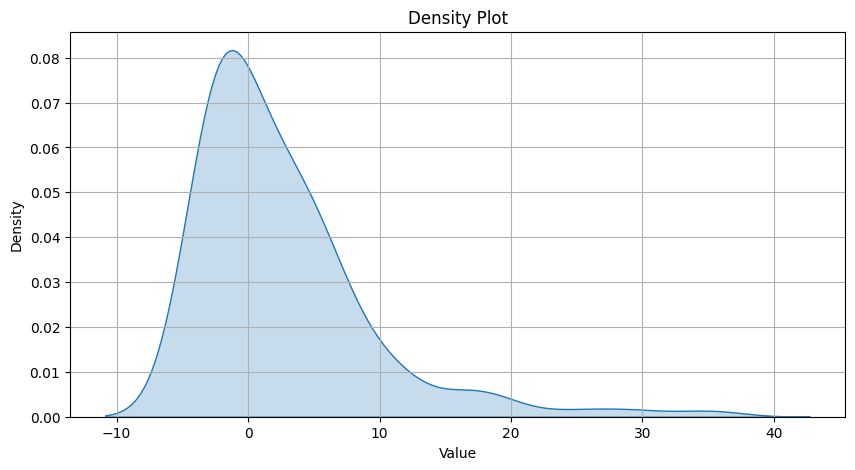

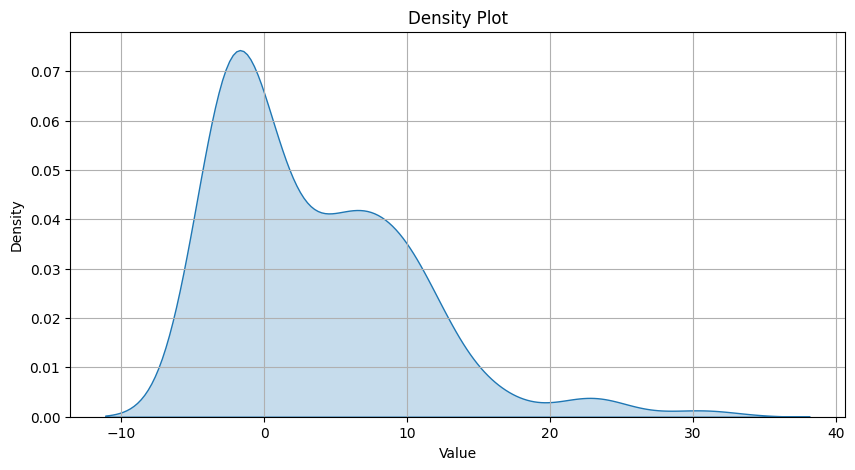

In [180]:
plot_density(np.sum(np.sum(distance_to_ref_patients, axis=1), axis=1))
plot_density(np.sum(np.sum(distance_to_ref_controls, axis=1), axis=1))
plot_density(np.sum(distance_to_ref_patients, axis=1)[0])
plot_density(np.sum(distance_to_ref_controls, axis=1)[0])

In [148]:
reference_matrix_2 = np.mean([
    np.where(patient_matrices['kl_divergence'] < 0.7, 0, 
                 patient_matrices['kl_divergence'])
    for patient_matrices in patients_connectomes.values()
])
distance_to_ref_patients_2 = [
    (reference_matrix_2 - np.where(patient_matrices['kl_divergence'] < 0.7, 0, 
                 patient_matrices['kl_divergence']))
    for patient_matrices in (patients_connectomes).values()]

distance_to_ref_controls_2 = [
    (reference_matrix_2 - np.where(patient_matrices['kl_divergence'] < 0.7, 0, 
                 patient_matrices['kl_divergence']))
    for patient_matrices in (controls_connectomes).values()]

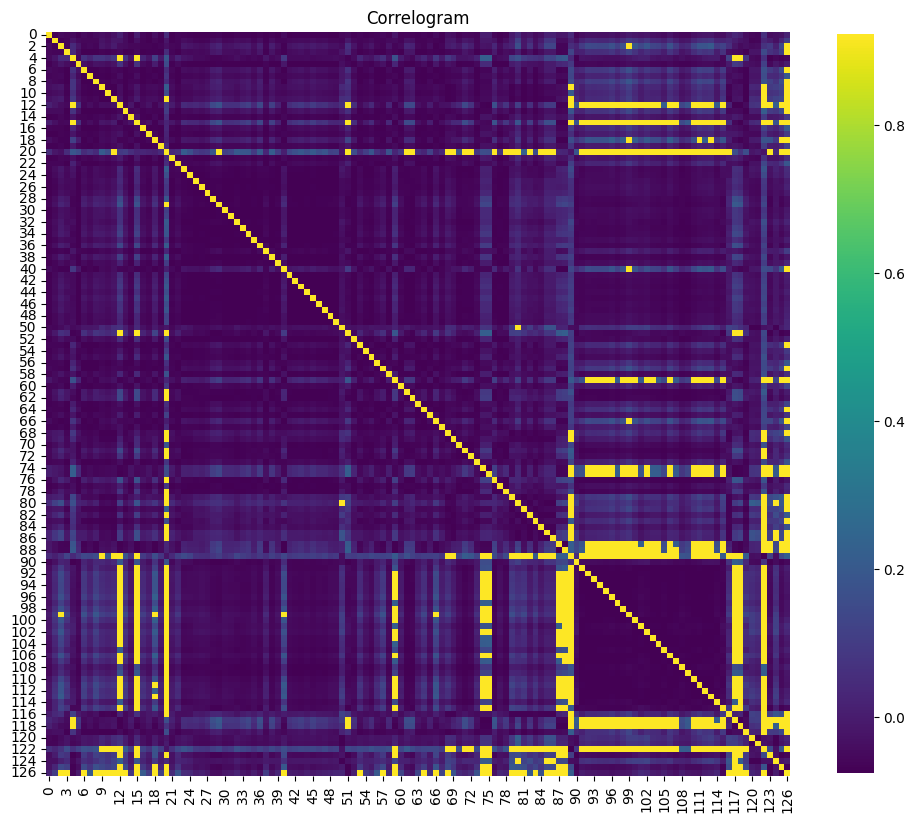

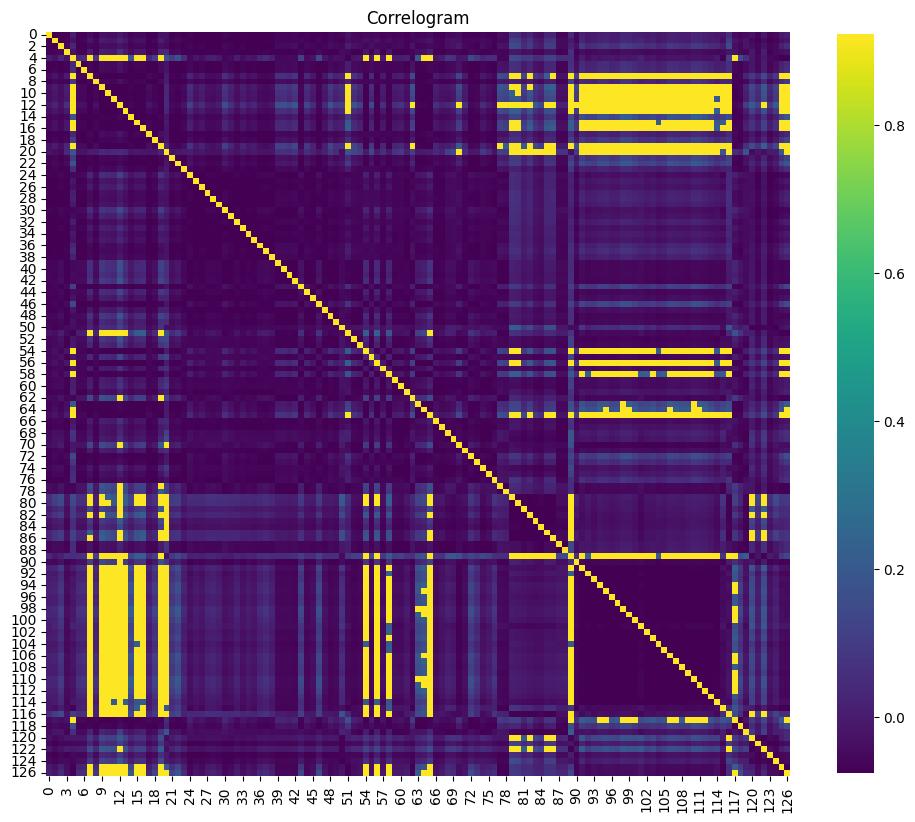

0.03390458066039478
5.912990574590979e-17
9.57916873395098e-13
0.031165612960360363
-0.006669742904416432
9.57916873395098e-13


In [176]:
plot_correlogram(distance_to_ref_patients_2[0])
plot_correlogram(distance_to_ref_controls_2[0])

print(np.var(distance_to_ref_patients_2))
print(np.mean(distance_to_ref_patients_2))
print(np.mean(np.sum(np.sum(distance_to_ref_patients_2, axis=1), axis=1)))
print(np.var(distance_to_ref_controls_2))
print(np.mean(distance_to_ref_controls_2))
print(np.mean(np.sum(np.sum(distance_to_ref_patients_2, axis=1), axis=1)))

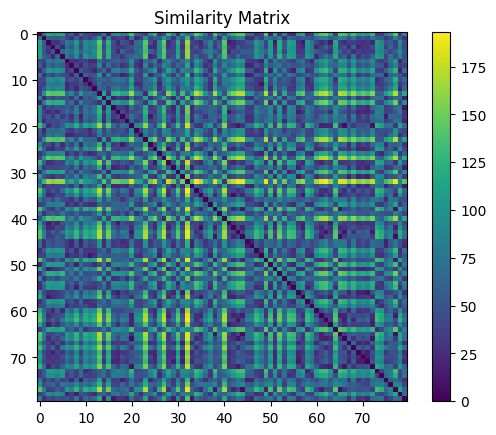

Cluster labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]


In [152]:
print("Cluster labels:", custom_spectral_clustering_on_similarity_matrix(compute_spectral_distance(distance_to_ref_patients_2+distance_to_ref_controls_2)))


In [186]:
from scipy.stats import gaussian_kde

def compute_column_sum_probabilities(test_matrix, set_of_matrices, epsilon=0.01):
    """
    For each matrix in set_of_matrices (each n x n), compute the sum of each column.
    Learn the distribution of these sums using kernel density estimation.
    Then, for each column in the test_matrix, compute the sum and approximate the 
    probability that a sample from the learned distribution falls within [x-epsilon, x+epsilon].
    
    Parameters:
      test_matrix (np.ndarray): An n x n matrix.
      set_of_matrices (list of np.ndarray): A list of n x n matrices.
      epsilon (float): Half the width of the interval around the observed column sum.
    
    Returns:
      probabilities (np.ndarray): An array of probabilities (one per column of test_matrix).
    """
    # Gather all column sums from the dataset
    dataset_column_sums = []
    for mat in set_of_matrices:
        # Compute column sums for each matrix (resulting in an array of shape (n,))
        dataset_column_sums.extend(np.sum(mat, axis=0))
    dataset_column_sums = np.array(dataset_column_sums)
    
    # Learn the distribution using kernel density estimation (non-parametric)
    kde = gaussian_kde(dataset_column_sums)
    
    # Compute column sums for the test matrix
    test_column_sums = np.sum(test_matrix, axis=0)
    
    # For each test column sum, compute the probability mass in [x - epsilon, x + epsilon]
    probabilities = np.array([
        max(0, kde.integrate_box_1d(x - epsilon, x + epsilon))
        for x in test_column_sums
    ])
    
    return probabilities


In [ ]:
controls_probs = []
patients_probs = []

for control in controls_list:
    col_sum_probs = compute_column_sum_probabilities(controls_connectomes[control]['kl_divergence'], [
        patient_matrices['kl_divergence']
        for patient_matrices in patients_connectomes.values()
    ], epsilon=0.001)
    controls_probs.append(np.sum(col_sum_probs))

#plot_density(col_sum_probs)
    
#print("Probability for each column sum:", np.sum(col_sum_probs))

for patient in patients_list:
    col_sum_probs = compute_column_sum_probabilities(patients_connectomes[patient]['kl_divergence'], [
        patient_matrices['kl_divergence']
        for patient_matrices in patients_connectomes.values()
    ], epsilon=0.001)
    patients_probs.append(np.sum(col_sum_probs))

#plot_density(col_sum_probs)
    
#print("Probability for each column sum:", np.sum(col_sum_probs))
print(patients_probs, "\n",np.mean(patients_probs), "\n", np.sum(patients_probs))
print(controls_probs, "\n", np.mean(controls_probs), "\n", np.sum(controls_probs))

[np.float64(0.017636101504213044), np.float64(0.026441860703869106), np.float64(0.02716951492470037), np.float64(0.024752488034452274), np.float64(0.026787367327996577), np.float64(0.025619111835283145), np.float64(0.02173354422313808), np.float64(0.02255280973790399), np.float64(0.018837086091819867), np.float64(0.0246320311190873), np.float64(0.023279189802335863), np.float64(0.022624767868185253), np.float64(0.01719619355130945), np.float64(0.015881778326509364), np.float64(0.025920345054101835), np.float64(0.01783847858164971), np.float64(0.02750774973815818), np.float64(0.02572766374134807), np.float64(0.024480893127385814), np.float64(0.026201512521887686), np.float64(0.02584522968063061), np.float64(0.022252841214884994), np.float64(0.023626085019054423), np.float64(0.015629138291924582), np.float64(0.02371084145497049), np.float64(0.025660278063833527), np.float64(0.02050551360756666)] 
 0.022964830190674083 
 0.6200504151482003
[np.float64(0.016287877946952006), np.float64(0.0

: 

The columns of patients are not more likely than the columns of the control x(

**Synthesis:** Overall we have tried to compute an individual connectome that exists without the group. This is a failure as the resulting networks are similar between the control and the patient group. This failure may be linked to a non consideration for the correlations between the organs' distributions. What can we do? Maybe try to construct the network in two steps: first as we did + then add a correlation part like what we tried to do with the mutual information.

### Experiment Abis: Let's try to incorporate the relations btw organs

In [3]:
import numpy as np

def build_adjacency_matrix2(organs, metric="kl_divergence", threshold=None, k=None, covariance_matrix=None):
    """
    Build the adjacency matrix for a graph of organs based on log-normal distribution parameters,
    incorporating mutual information derived from covariance between organs.

    Parameters:
        organs (dict): Dictionary where keys are organ names and values are (mean, variance) tuples.
        metric (str): Distance metric to use ("kl_divergence", "euclidean-on-log", "bhattacharyya").
        threshold (float, optional): Maximum allowed distance to connect nodes (used for threshold-based graphs).
        k (int, optional): Number of nearest neighbors to connect each node (used for k-NN graphs).
        covariance_matrix (np.ndarray, optional): Covariance matrix between log-transformed organ variables.

    Returns:
        np.ndarray: Adjusted adjacency matrix (symmetric).
        list: Ordered list of organ names corresponding to matrix indices.
    """
    organ_names = list(organs.keys())
    num_organs = len(organ_names)
    
    organ_vectors = np.array([organs[name] for name in organ_names])
    
    log_mu = np.log(organ_vectors[:, 0]**2 / np.sqrt(organ_vectors[:, 1] + organ_vectors[:, 0]**2))
    log_sigma_sq = np.log(organ_vectors[:, 1] / organ_vectors[:, 0]**2 + 1)

    distance_matrix = np.zeros((num_organs, num_organs))

    # Compute original distance matrix
    if metric == "kl_divergence":
        def kl_divergence(i, j):
            mu1, sigma1_sq = log_mu[i], log_sigma_sq[i]
            mu2, sigma2_sq = log_mu[j], log_sigma_sq[j]
            return 0.5 * (sigma2_sq / sigma1_sq + (mu1 - mu2)**2 / sigma1_sq - 1 + np.log(sigma1_sq / sigma2_sq))

        for i in range(num_organs):
            for j in range(i + 1, num_organs):
                dist = kl_divergence(i, j) + kl_divergence(j, i)
                distance_matrix[i, j] = dist
                distance_matrix[j, i] = dist

    elif metric == "euclidean-on-log":
        log_vectors = np.vstack((log_mu, log_sigma_sq)).T
        for i in range(num_organs):
            for j in range(i + 1, num_organs):
                dist = np.linalg.norm(log_vectors[i] - log_vectors[j])
                distance_matrix[i, j] = dist
                distance_matrix[j, i] = dist

    elif metric == "bhattacharyya":
        def bhattacharyya(i, j):
            mu1, sigma1_sq = log_mu[i], log_sigma_sq[i]
            mu2, sigma2_sq = log_mu[j], log_sigma_sq[j]
            return 0.25 * np.log(0.25 * (sigma1_sq / sigma2_sq + sigma2_sq / sigma1_sq + 2)) + \
                   0.25 * ((mu1 - mu2)**2 / (sigma1_sq + sigma2_sq))

        for i in range(num_organs):
            for j in range(i + 1, num_organs):
                dist = bhattacharyya(i, j)
                distance_matrix[i, j] = dist
                distance_matrix[j, i] = dist

    else:
        raise ValueError("Unsupported metric. Choose 'kl_divergence', 'euclidean-on-log', or 'bhattacharyya'.")

    # Adjust distance matrix with mutual information from covariance_matrix
    if covariance_matrix is not None:
        sigma = np.sqrt(np.diag(covariance_matrix))
        corr_matrix = covariance_matrix / np.outer(sigma, sigma)
        np.fill_diagonal(corr_matrix, 1.0)  # Avoid division issues
        
        # Compute mutual information matrix
        with np.errstate(divide='ignore', invalid='ignore'):
            mi_matrix = -0.5 * np.log(1 - np.square(corr_matrix))
        mi_matrix = np.nan_to_num(mi_matrix, nan=0.0, posinf=0.0, neginf=0.0)
        np.fill_diagonal(mi_matrix, 0)
        
        # Normalize mutual information to [0, 1]
        mi_max = np.max(mi_matrix)
        if mi_max > 0:
            mi_matrix /= mi_max
        
        # Adjust distances: higher MI reduces distance
        distance_matrix *= (1 - mi_matrix)

    # Build adjacency matrix based on threshold or k-NN
    adjacency_matrix = np.zeros((num_organs, num_organs))

    if threshold is not None:
        if threshold != 0:
            adjacency_matrix[distance_matrix < threshold] = 1
        else:    
            adjacency_matrix = np.exp(-distance_matrix)

    elif k is not None:
        for i in range(num_organs):
            nearest_indices = np.argsort(distance_matrix[i])[1:k+1]
            adjacency_matrix[i, nearest_indices] = 1
            adjacency_matrix[nearest_indices, i] = 1

    np.fill_diagonal(adjacency_matrix, 0)

    return adjacency_matrix, organ_names

In [4]:
def compute_pairwise_covariance(organs):
    """
    Compute the pairwise covariance matrix between organs based on the log-transformed 
    parameters of their log-normal distributions.

    Parameters:
        organs (dict): Dictionary where keys are organ names and values are (mean, variance) tuples.

    Returns:
        np.ndarray: Pairwise covariance matrix of shape (num_organs, num_organs).
        list: Ordered list of organ names corresponding to matrix indices.
    """
    organ_names = list(organs.keys())
    num_organs = len(organ_names)
    
    # Convert organ dictionary to a NumPy array for easier computation
    organ_vectors = np.array([organs[name] for name in organ_names])
    
    # Convert (mean, variance) to underlying normal parameters (log_mu, log_sigma_sq)
    log_mu = np.log(organ_vectors[:, 0]**2 / np.sqrt(organ_vectors[:, 1] + organ_vectors[:, 0]**2))
    log_sigma_sq = np.log(organ_vectors[:, 1] / organ_vectors[:, 0]**2 + 1)
    
    # Stack transformed parameters into a (num_organs, 2) matrix
    log_params = np.vstack((log_mu, log_sigma_sq)).T  

    # Compute the covariance matrix between organs
    covariance_matrix = np.zeros((num_organs, num_organs))

    for i in range(num_organs):
        for j in range(i, num_organs):  # Only compute upper triangle, then mirror
            cov = np.cov(log_params[i], log_params[j])[0, 1]
            covariance_matrix[i, j] = cov
            covariance_matrix[j, i] = cov  # Ensure symmetry

    return covariance_matrix, organ_names

In [15]:
from scipy.interpolate import interp1d

def resample_vectors(vectors):
    """
    Resamples longer vectors to match the length of the shortest vector,
    preserving the approximate distribution.

    Args:
        vectors: A list of NumPy arrays (vectors) of potentially different lengths.

    Returns:
        A list of resampled NumPy arrays, all with the length of the shortest vector.
    """

    if not isinstance(vectors, (list, np.ndarray)) or len(vectors) == 0: 
        return []

    lengths = [len(v) for v in vectors]
    min_length = min(lengths)

    resampled_vectors = []
    for vector in vectors:
        if len(vector) == min_length:
            resampled_vectors.append(vector)
        else:
            # Interpolate the vector
            x_original = np.linspace(0, 1, len(vector))
            x_resampled = np.linspace(0, 1, min_length)
            f = interp1d(x_original, vector, kind='linear', fill_value="extrapolate") #use linear interpolation
            resampled_vectors.append(f(x_resampled))

    return resampled_vectors

def compute_pairwise_covariance(organs, mode="data"):
    """
    Compute the pairwise covariance matrix between organs

    Parameters:
        organs (dict): Dictionary where keys are organ names and values are (mean, variance) tuples.
        mode (string): "data" or "parameters" : if data we compute the actual covariance, if parameters we compute the cov based on the log-transformed 
    parameters of their log-normal distributions.

    Returns:
        np.ndarray: Pairwise covariance matrix between organs.
        list: Ordered list of organ names corresponding to matrix indices.
    """
    if mode == "data":
        if type(organs) != np.ndarray:
            organ_names = list(organs.keys())
            # Stack organ data into a matrix (rows = organs, columns = samples)
            data_matrix = np.vstack([organs[name] for name in organ_names])
        else:
            organ_names = []
            data_matrix = resample_vectors(organs)
            
        # Compute the covariance matrix (num_organs x num_organs)
        covariance_matrix = np.cov(data_matrix)
    else: 
        organ_names = list(organs.keys())
        # Convert organ dictionary to a NumPy array for easier computation
        organ_vectors = np.array([organs[name] for name in organ_names])
        
        # Convert (mean, variance) to underlying normal parameters (log_mu, log_sigma_sq)
        log_mu = np.log(organ_vectors[:, 0]**2 / np.sqrt(organ_vectors[:, 1] + organ_vectors[:, 0]**2))
        log_sigma_sq = np.log(organ_vectors[:, 1] / organ_vectors[:, 0]**2 + 1)
        
        # Stack transformed parameters into a (num_organs, 2) matrix
        log_params = np.vstack((log_mu, log_sigma_sq)).T  

        # Compute the covariance matrix between organs (num_organs x num_organs)
        covariance_matrix = np.cov(log_params, rowvar=False)  

    return covariance_matrix, organ_names

In [16]:
patients_connectomes = {}
controls_connectomes = {}

for patient in patients_list:
    organs_raw = patients_data[patient].loc["SUV"].to_numpy()
    organs = build_organ_dict(organs_raw)
    cov, _ = compute_pairwise_covariance(organs_raw)
    adj_matrix, organ_names = build_adjacency_matrix2(organs, metric="bhattacharyya", threshold=0, covariance_matrix=cov)
    adj_matrix2, organ_names2 = build_adjacency_matrix2(organs, metric="kl_divergence", threshold=0, covariance_matrix=cov)
    adj_matrix3, organ_names3 = build_adjacency_matrix2(organs, metric="euclidean-on-log", threshold=0, covariance_matrix=cov)
    #patients_connectomes[patient] = {'bhattacharyya': normalize_matrix_no_diagonal(adj_matrix), 
    #                                 'kl_divergence': normalize_matrix_no_diagonal(adj_matrix2), 
    #                                 'euclidean-on-log': normalize_matrix_no_diagonal(adj_matrix3), 
    #                                 'organs': organs}
    patients_connectomes[patient] = {'bhattacharyya': (adj_matrix), 
                                     'kl_divergence': (adj_matrix2), 
                                     'euclidean-on-log': (adj_matrix3), 
                                     'organs': organs}

for patient in controls_list:
    organs_raw = controls_data[patient].loc["SUV"].to_numpy()
    organs = build_organ_dict(organs_raw)
    cov, _ = compute_pairwise_covariance(organs_raw)
    adj_matrix, organ_names = build_adjacency_matrix2(organs, metric="bhattacharyya", threshold=0, covariance_matrix=cov)
    adj_matrix2, organ_names2 = build_adjacency_matrix2(organs, metric="kl_divergence", threshold=0, covariance_matrix=cov)
    adj_matrix3, organ_names3 = build_adjacency_matrix2(organs, metric="euclidean-on-log", threshold=0, covariance_matrix=cov)
    #controls_connectomes[patient] = {'bhattacharyya': normalize_matrix_no_diagonal(adj_matrix), 
    #                                 'kl_divergence': normalize_matrix_no_diagonal(adj_matrix2), 
    #                                 'euclidean-on-log': normalize_matrix_no_diagonal(adj_matrix3), 
    #                                 'organs': organs}
    controls_connectomes[patient] = {'bhattacharyya': (adj_matrix), 
                                     'kl_divergence': (adj_matrix2), 
                                     'euclidean-on-log': (adj_matrix3), 
                                     'organs': organs}
    
del controls_data, patients_data, organs


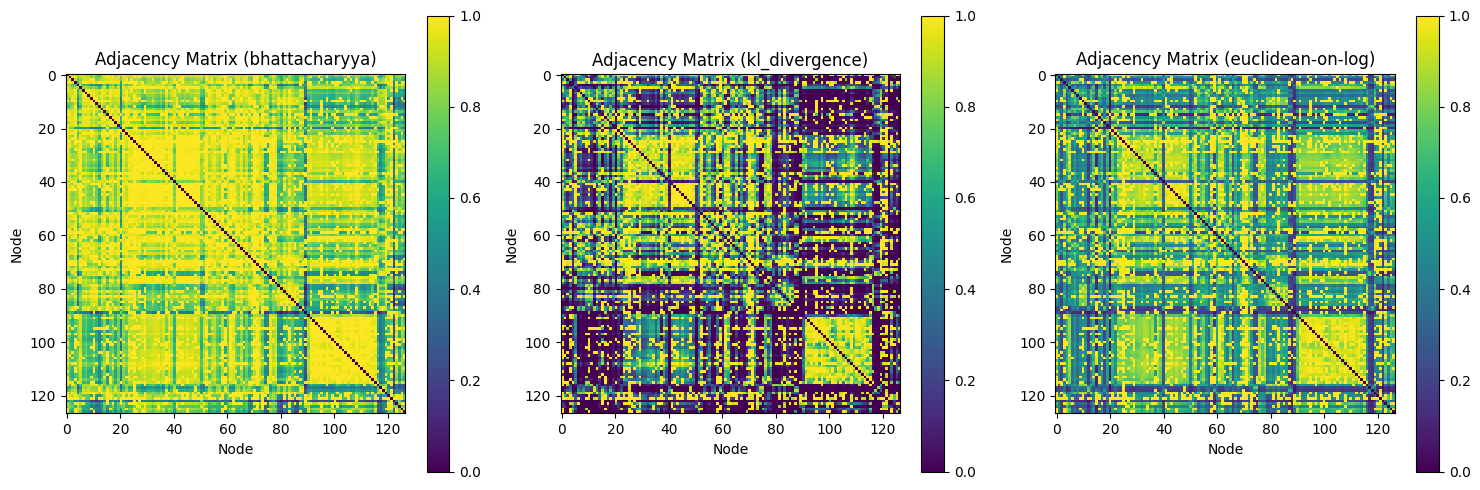

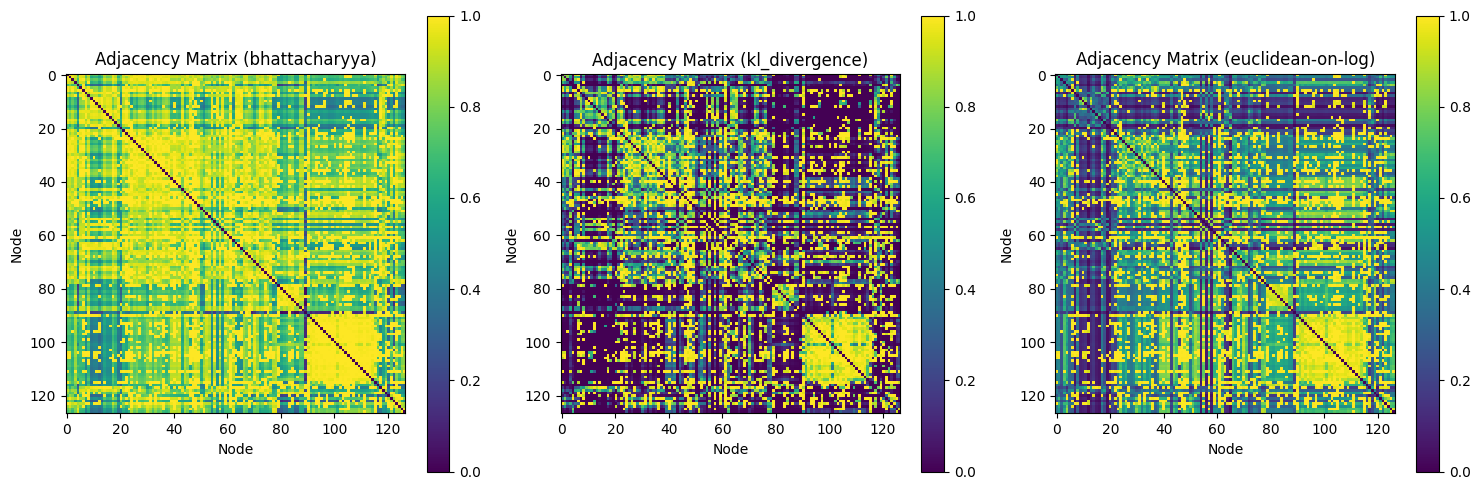

In [51]:
print_adjacency_matrices(patients_connectomes[patients_list[0]])

print_adjacency_matrices(controls_connectomes[controls_list[0]])

In [17]:
reference_matrix = np.mean([
    patient_matrices['kl_divergence']
    for patient_matrices in patients_connectomes.values()
], axis=0)
distance_to_ref_patients = [
    (reference_matrix - patient_matrices['kl_divergence'])
    for patient_matrices in (patients_connectomes).values()]

distance_to_ref_controls = [
    (reference_matrix - patient_matrices['kl_divergence'])
    for patient_matrices in (controls_connectomes).values()]

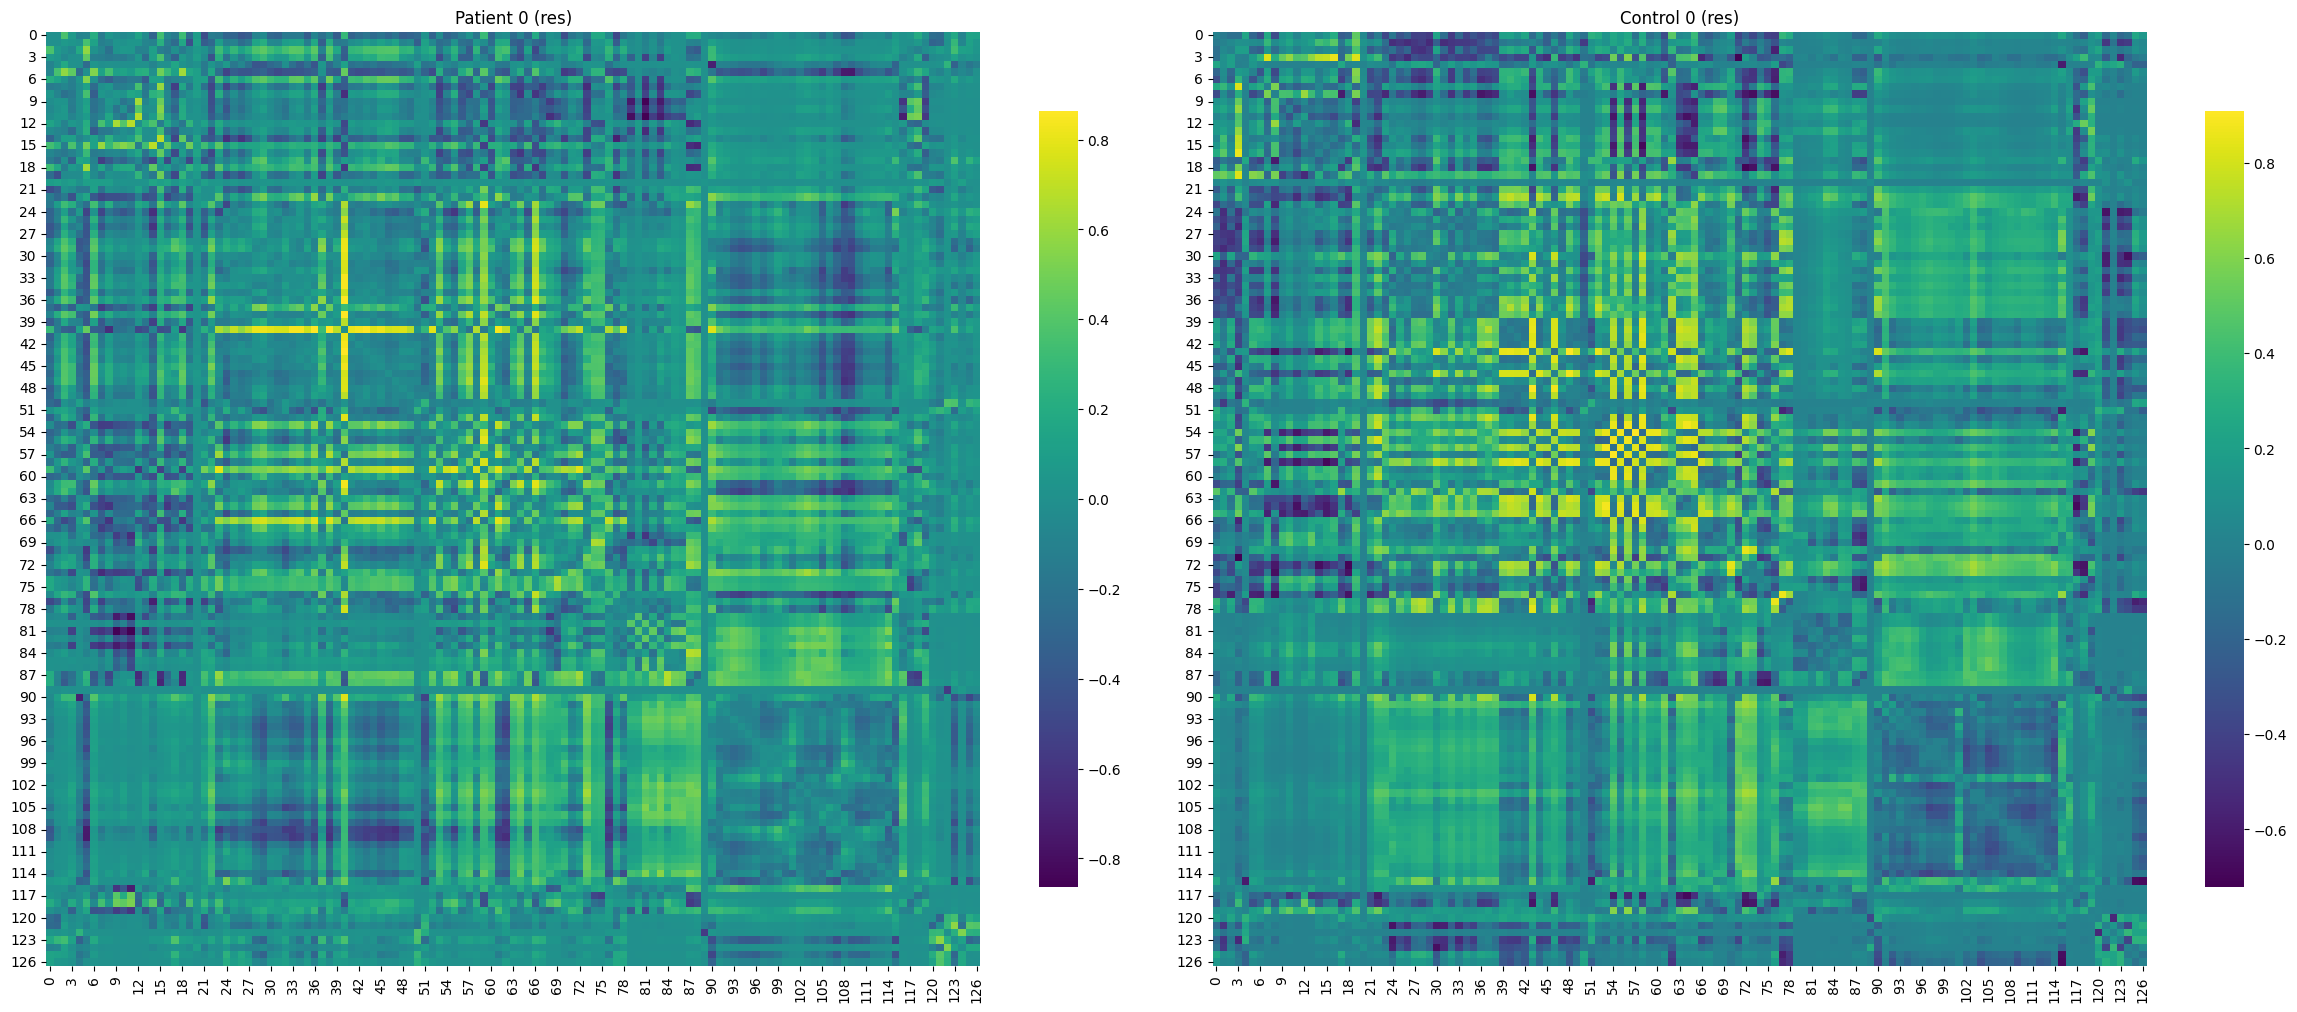

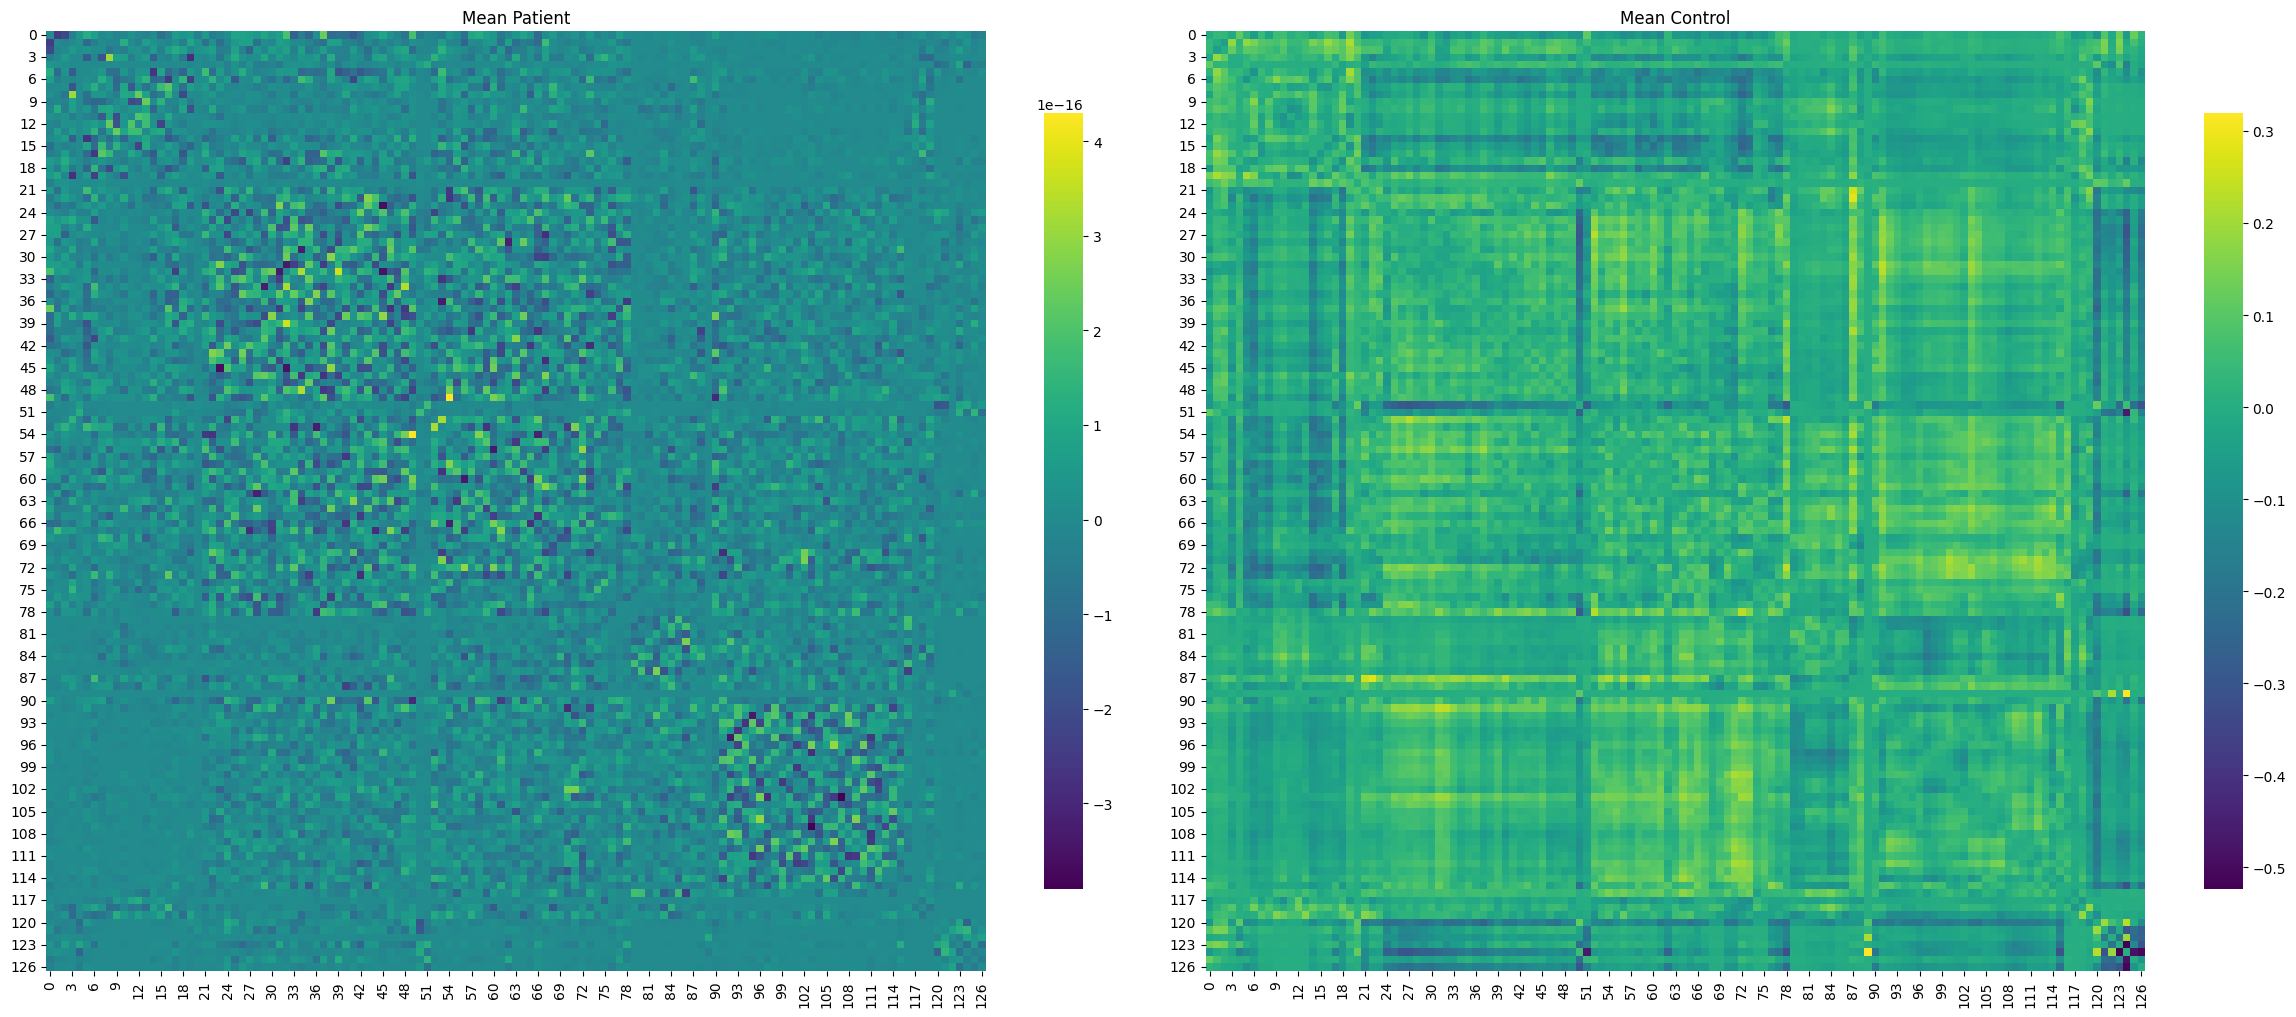

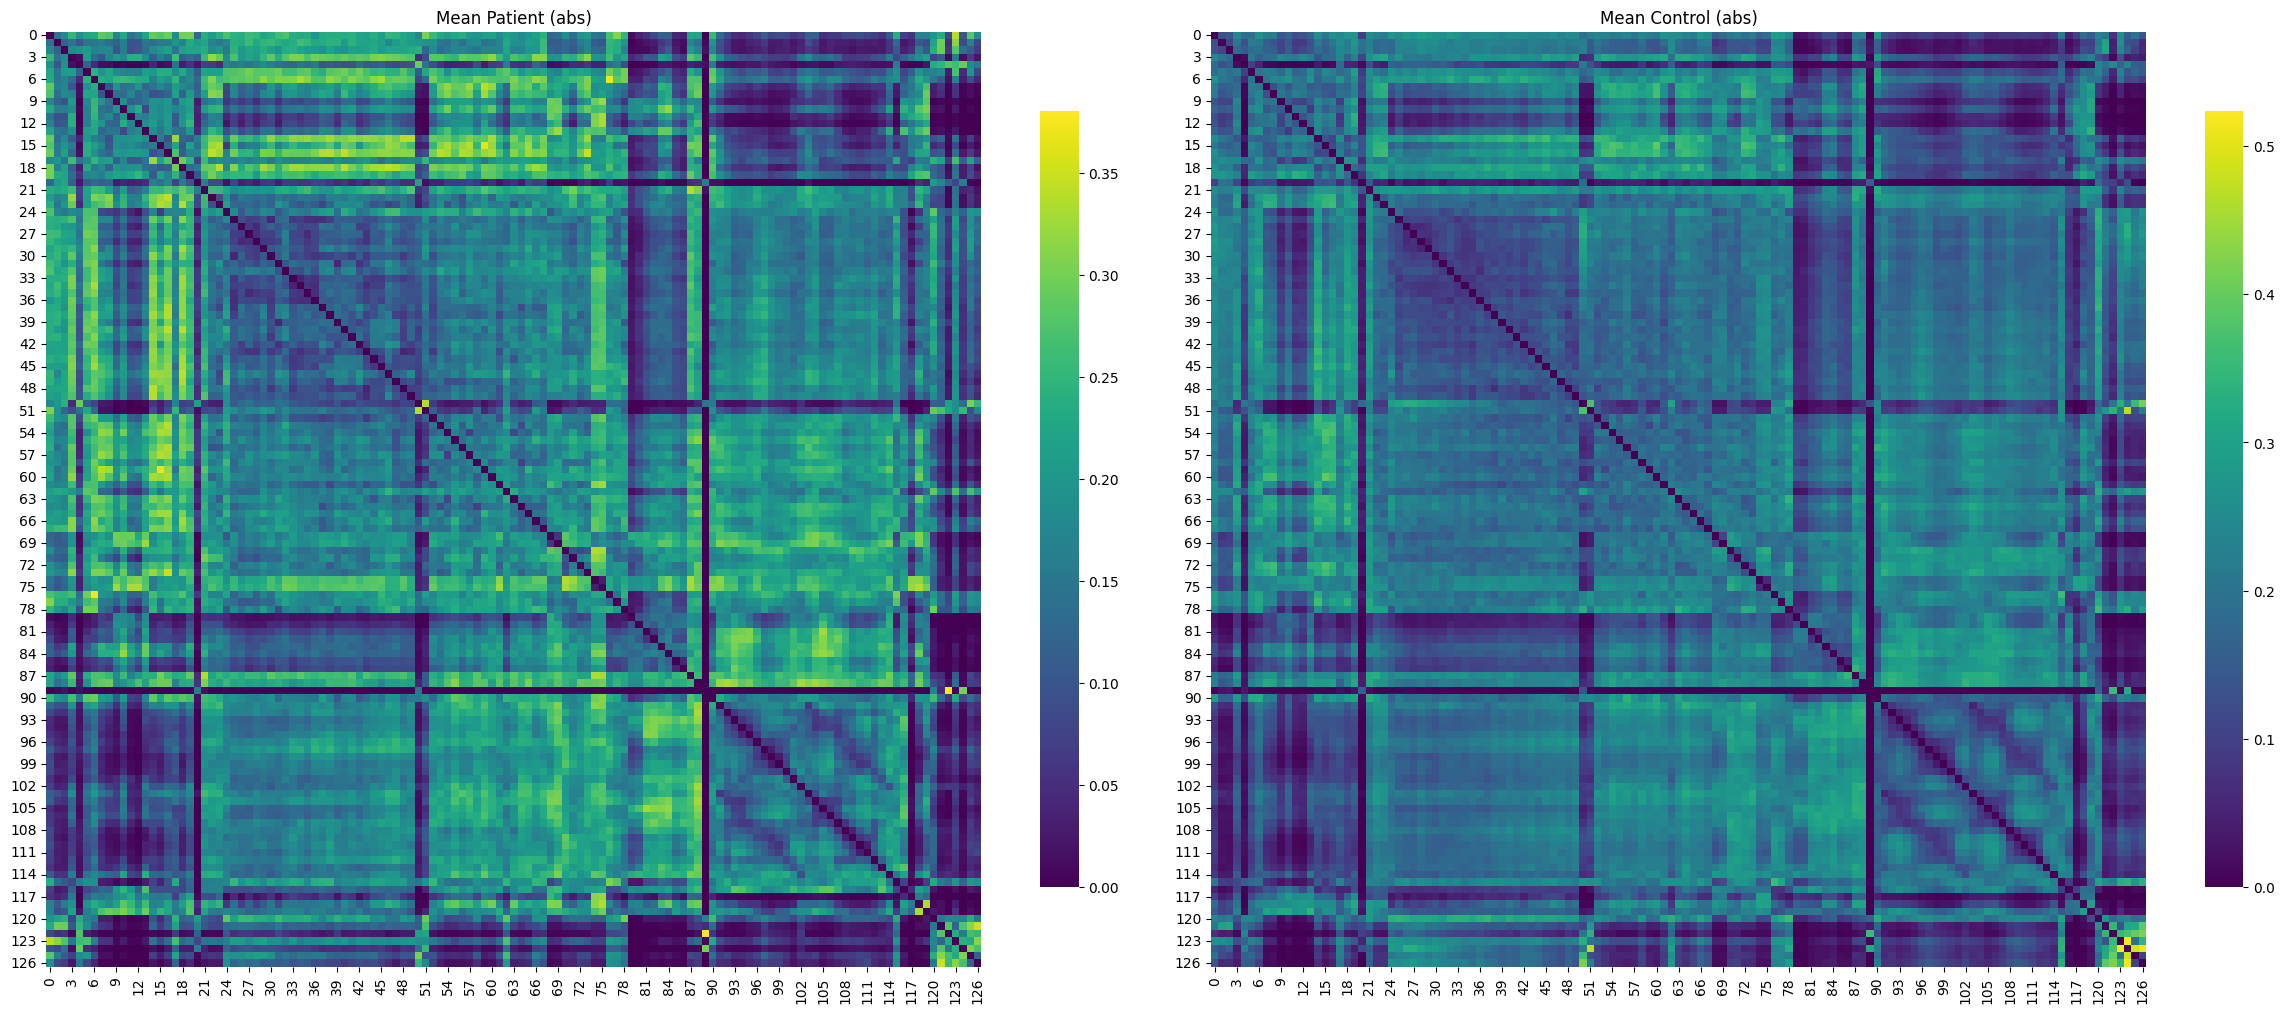

In [ ]:
plot_correlogram(distance_to_ref_patients[0], distance_to_ref_controls[0], titles=["Patient 0 (res)", "Control 0 (res)"])
plot_correlogram(np.mean(distance_to_ref_patients, axis=0), np.mean(distance_to_ref_controls, axis=0), titles=["Mean Res Patient", "Mean Res Control"])
plot_correlogram(np.mean(np.abs(distance_to_ref_patients), axis=0), np.mean(np.abs(distance_to_ref_controls), axis=0), titles=["Mean Res Patient (abs)", "Mean Res Control (abs)"])



In [19]:
print(np.mean(np.mean(distance_to_ref_patients, axis=1), axis=1), np.mean(np.mean(np.mean(distance_to_ref_patients, axis=1), axis=1)))
print(np.mean(np.mean(distance_to_ref_controls, axis=1), axis=1), np.mean(np.mean(np.mean(distance_to_ref_controls, axis=1), axis=1)))

[ 0.02329492 -0.03200936 -0.06973665  0.06088379 -0.06261363 -0.00290707
 -0.06214523  0.0755933   0.01465539 -0.01111427 -0.02009677 -0.01271635
  0.04142353  0.0252476  -0.0249259   0.03428852 -0.03858617 -0.05208196
  0.06047991 -0.02831255 -0.00727308  0.01679203 -0.02791192  0.05563157
  0.04941105 -0.01509005  0.00981937] 1.02798428206033e-18
[ 0.1052625  -0.06211878  0.00541244  0.08256717 -0.02741193  0.10851349
 -0.03717325 -0.13486456  0.02158738  0.03693901  0.05030041  0.05353528
  0.00260073  0.06076976  0.0494666  -0.02974864 -0.04525453  0.02497753
  0.06902709 -0.01096895  0.02389615  0.01338075  0.06891218 -0.00083001
 -0.02160786  0.00587318 -0.09848457  0.05420935 -0.00389796  0.00864465
  0.05174031  0.07051117  0.02853699  0.05516785 -0.08677783 -0.11155263
 -0.00751519  0.03096499  0.03634532 -0.0333149   0.02998133 -0.05382393
 -0.02262106 -0.07899436 -0.04729724 -0.00645354  0.00041267  0.03550197
  0.09292714 -0.12410763 -0.00387276 -0.00303604 -0.0480189 ] 0.0

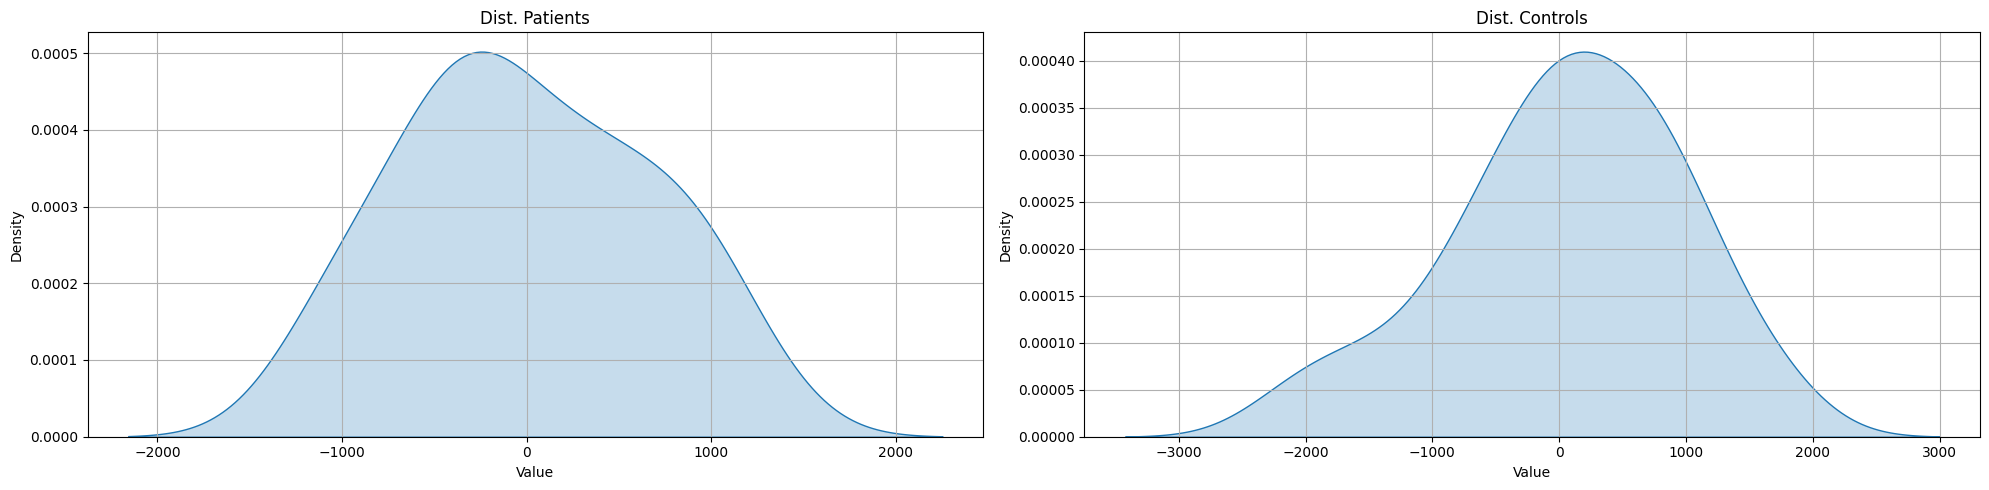

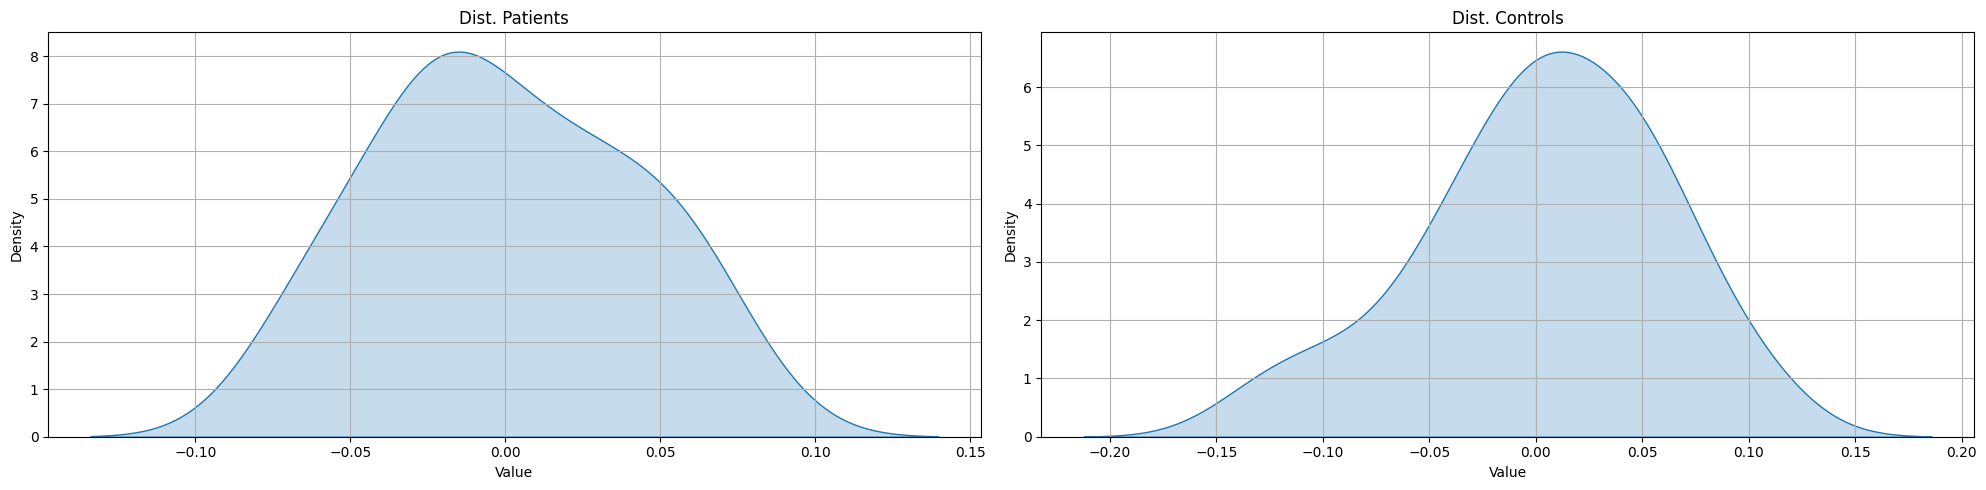

T-statistic: -0.3013063566021974
P-value: 0.7640913403073226
No statistically significant difference found (p >= 0.05).


In [20]:
plot_density(np.sum(np.sum(distance_to_ref_patients, axis=1), axis=1),np.sum(np.sum(distance_to_ref_controls, axis=1), axis=1), titles=["Dist. Patients", "Dist. Controls"])
plot_density(np.mean(np.mean(distance_to_ref_patients, axis=1), axis=1),np.mean(np.mean(distance_to_ref_controls, axis=1), axis=1), titles=["Dist. Patients", "Dist. Controls"])

_ ,_ = do_t_test(np.mean(np.mean(distance_to_ref_patients, axis=1), axis=1), np.mean(np.mean(distance_to_ref_controls, axis=1), axis=1))


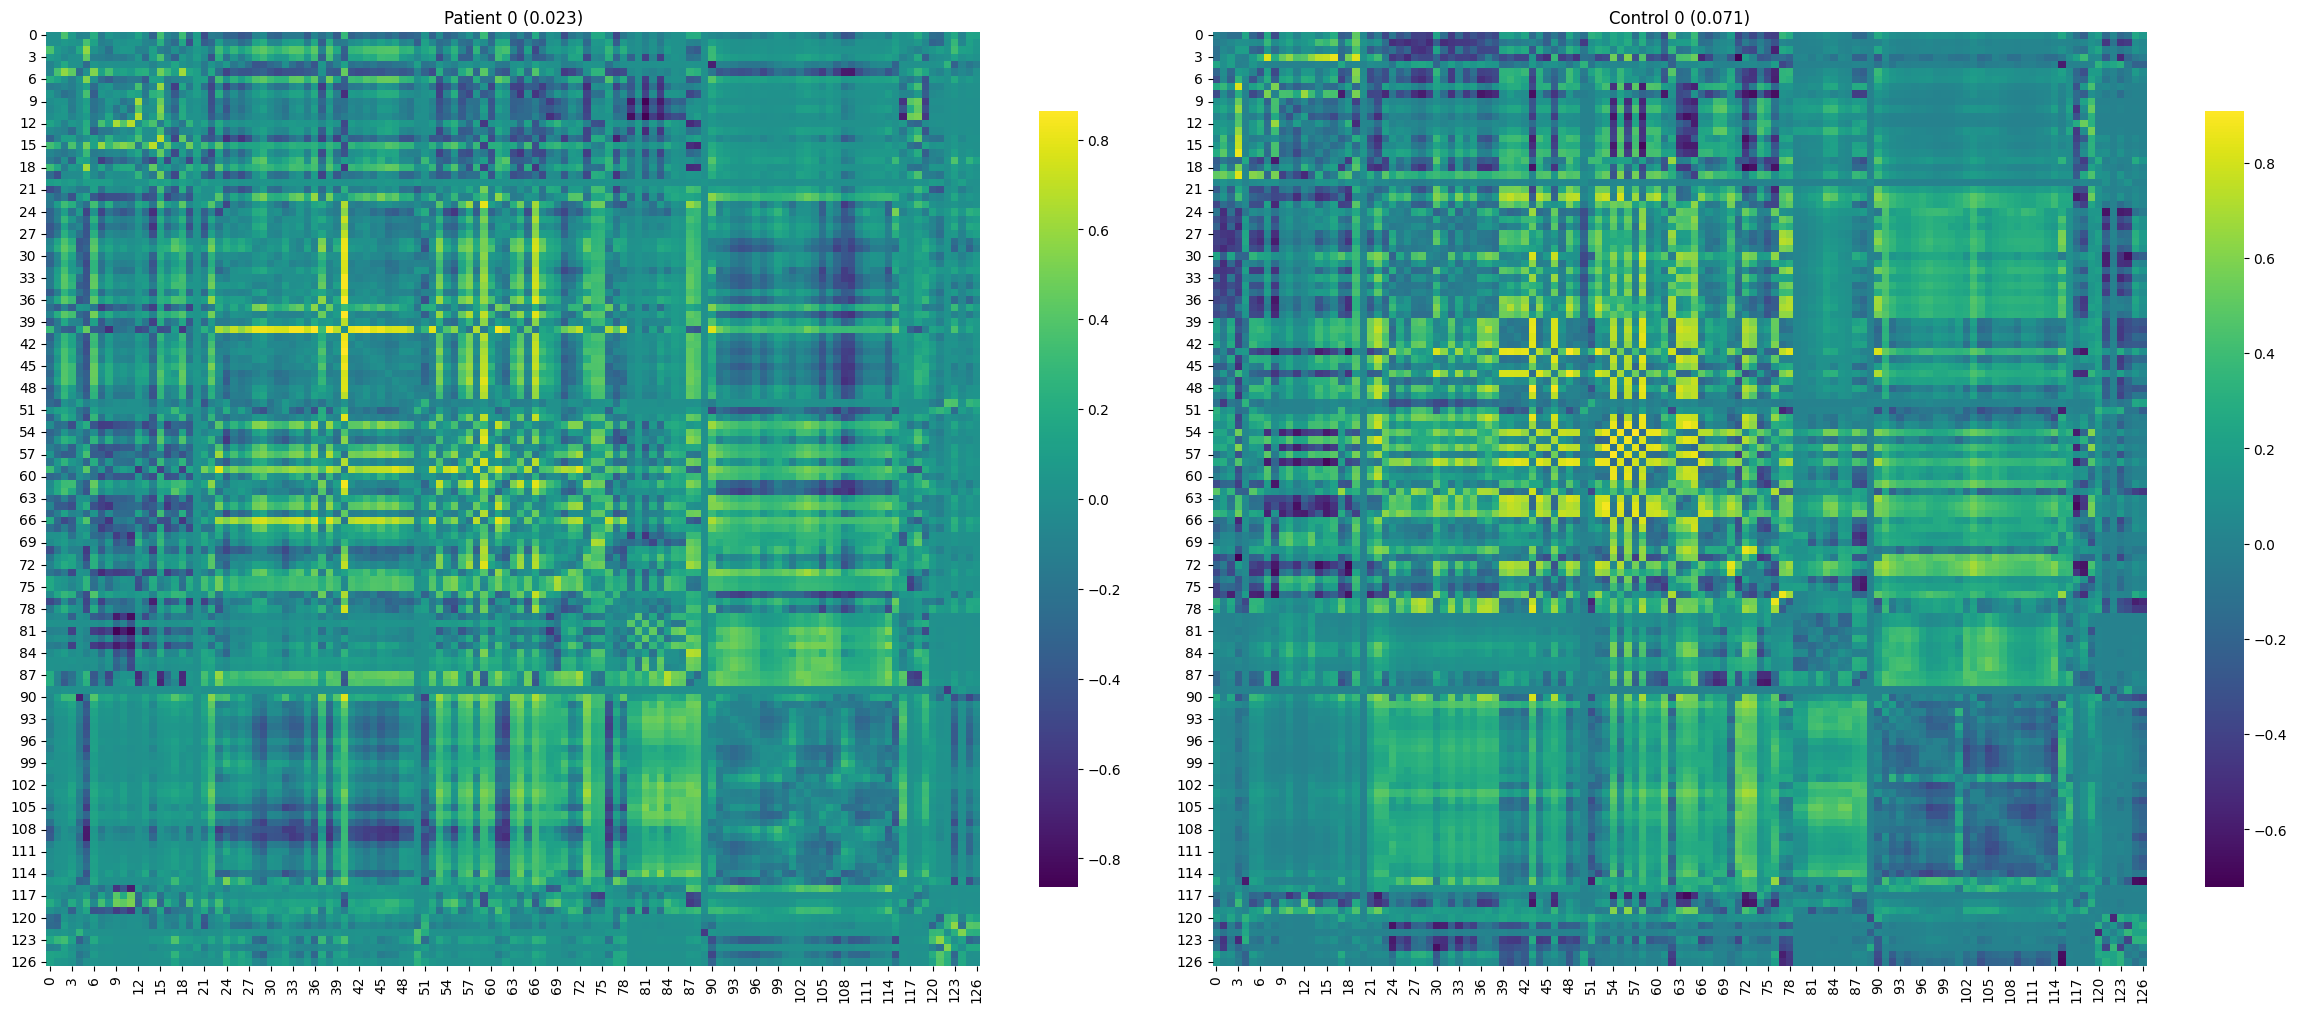

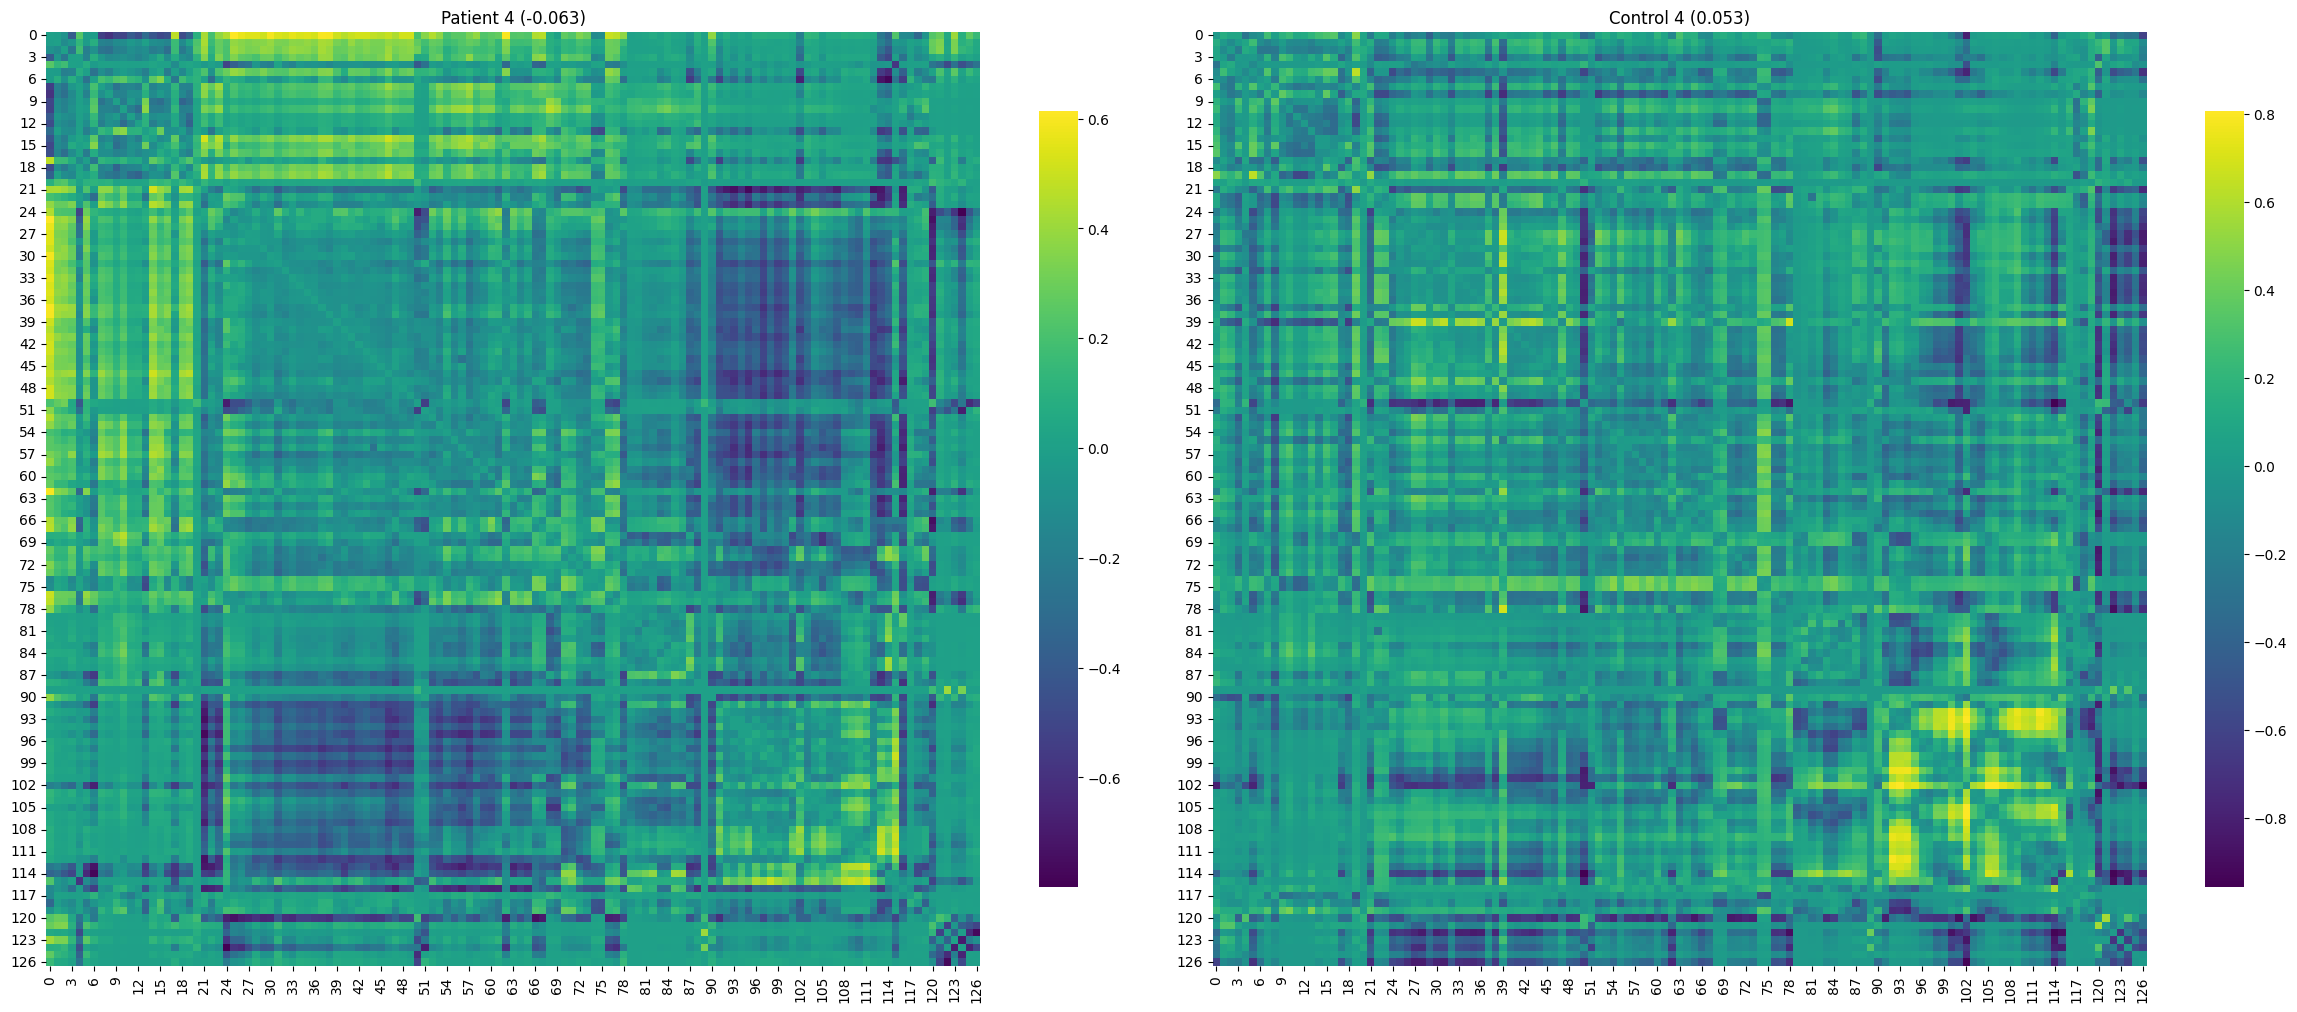

In [21]:
plot_correlogram(distance_to_ref_patients[0], distance_to_ref_controls[0], titles=[f"Patient 0 ({np.mean(distance_to_ref_patients[0]):.3f})", f"Control 0 ({np.mean((np.abs(distance_to_ref_controls)**2)[0]):.3f})"])
plot_correlogram(distance_to_ref_patients[4], distance_to_ref_controls[4], titles=[f"Patient 4 ({np.mean(distance_to_ref_patients[4]):.3f})", f"Control 4 ({np.mean((np.abs(distance_to_ref_controls)**2)[4]):.3f})"])


In [22]:
def pairwise_covariance_matrices(matrix_vector):
    """
    Computes the pairwise covariance between a vector of same-size matrices.

    Args:
        matrix_vector: A list or NumPy array of NumPy matrices, all with the same shape.

    Returns:
        A NumPy array representing the pairwise covariance matrix.
        The shape of the returned matrix will be (n, n), where n is the number of matrices.
    """

    if not isinstance(matrix_vector, (list, np.ndarray)):
        raise TypeError("Input 'matrix_vector' must be a list or NumPy array.")

    if not matrix_vector:
        return np.array([])  # Return empty array if input is empty

    num_matrices = len(matrix_vector)
    matrix_shape = matrix_vector[0].shape

    # Check if all elements are matrices and have the same shape
    for matrix in matrix_vector:
        if not isinstance(matrix, np.ndarray) or matrix.shape != matrix_shape:
            raise ValueError("All elements in 'matrix_vector' must be NumPy matrices with the same shape.")

    # Flatten each matrix into a 1D vector
    flattened_matrices = [matrix.flatten() for matrix in matrix_vector]

    # Compute the covariance matrix of the flattened vectors
    covariance_matrix = np.cov(flattened_matrices)

    return covariance_matrix

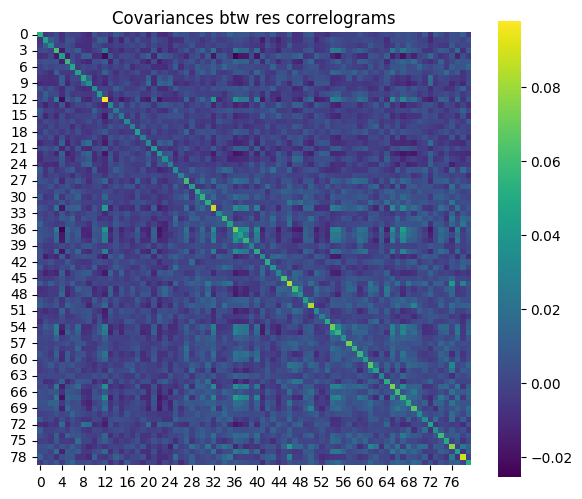

-2.6651444349712265e-19
0.005068704032391777
T-statistic: -13.1692977264283
P-value: 2.2585829865806732e-35
There is a statistically significant difference between distribA and distribB (p < 0.05).


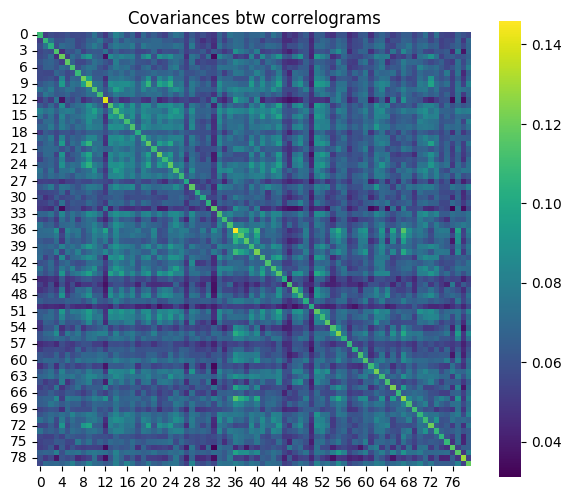

0.07217355039473108
0.06539253938675922
T-statistic: 8.77496302578821
P-value: 2.0038220661572486e-17
There is a statistically significant difference between distribA and distribB (p < 0.05).


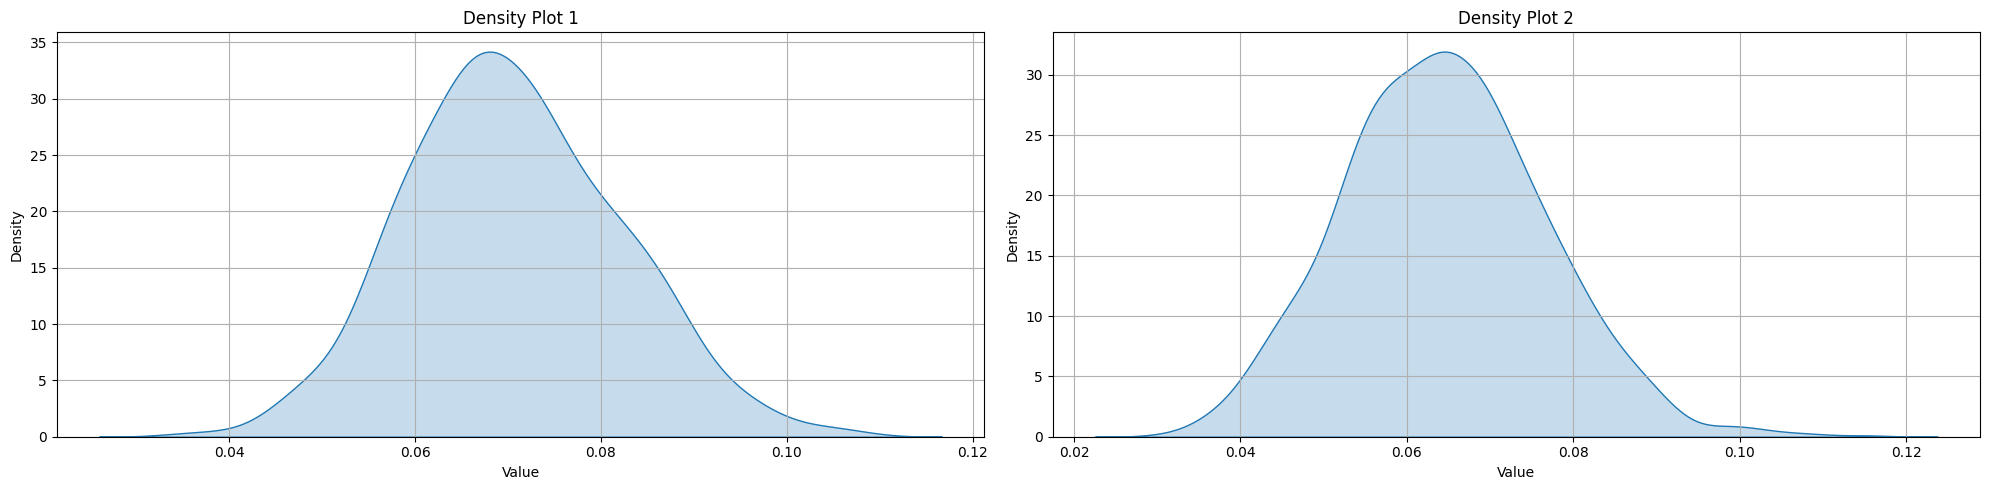

In [23]:
plot_correlogram(pairwise_covariance_matrices(distance_to_ref_patients + distance_to_ref_controls), titles=["Covariances btw res correlograms"])
print(np.mean(pairwise_covariance_matrices(distance_to_ref_patients)))
print(np.mean(pairwise_covariance_matrices(distance_to_ref_controls)))
_, _ =do_t_test(upper_triangle_to_vector(pairwise_covariance_matrices(distance_to_ref_patients)), upper_triangle_to_vector(pairwise_covariance_matrices(distance_to_ref_controls)))


plot_correlogram(pairwise_covariance_matrices([(patient_matrices['kl_divergence']) for patient_matrices in (patients_connectomes | controls_connectomes).values()]
), titles=["Covariances btw correlograms"])
print(np.mean(pairwise_covariance_matrices([(patient_matrices['kl_divergence']) for patient_matrices in (patients_connectomes).values()]
)))
print(np.mean(pairwise_covariance_matrices([(patient_matrices['kl_divergence']) for patient_matrices in (controls_connectomes).values()]
)))
_, _ =do_t_test(upper_triangle_to_vector(pairwise_covariance_matrices([(patient_matrices['kl_divergence']) for patient_matrices in (patients_connectomes).values()])), upper_triangle_to_vector(pairwise_covariance_matrices([(patient_matrices['kl_divergence']) for patient_matrices in (controls_connectomes).values()])))
plot_density(upper_triangle_to_vector(pairwise_covariance_matrices([(patient_matrices['kl_divergence']) for patient_matrices in (patients_connectomes).values()])), upper_triangle_to_vector(pairwise_covariance_matrices([(patient_matrices['kl_divergence']) for patient_matrices in (controls_connectomes).values()])))


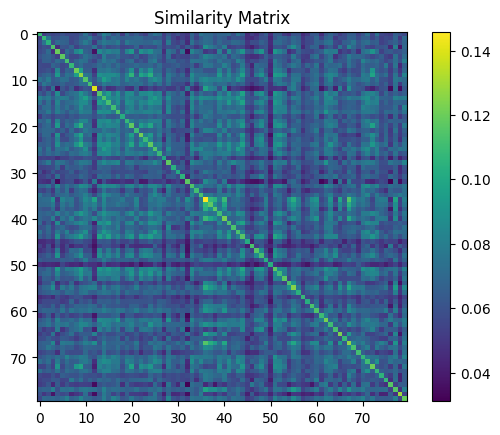

[1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 0
 0 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 1
 0 0 1 0 1 0]
['patient', 'patient', 'patient', 'patient', 'patient', 'patient', 'patient', 'patient', 'patient', 'patient', 'patient', 'patient', 'patient', 'patient', 'patient', 'patient', 'patient', 'patient', 'patient', 'patient', 'patient', 'patient', 'patient', 'patient', 'patient', 'patient', 'patient', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control', 'control',

In [ ]:
combined_connectomes = {**patients_connectomes, **controls_connectomes}
clustering = custom_spectral_clustering_on_similarity_matrix(pairwise_covariance_matrices([(patient_matrices['kl_divergence']) for patient_matrices in combined_connectomes.values()]
))

result_list = []
for key, value in combined_connectomes.items():
    if key in patients_connectomes:
        result_list.append('patient')
    elif key in controls_connectomes:
        result_list.append('control')


print(clustering)
print(result_list)

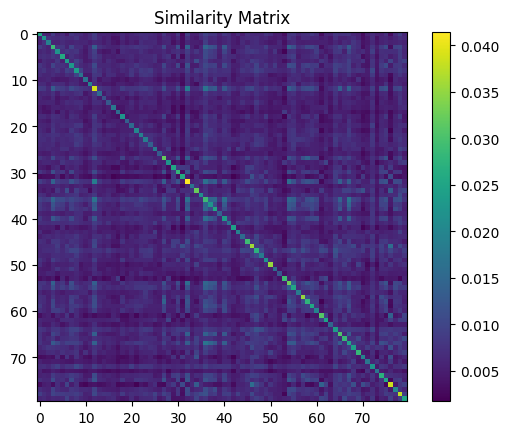

[1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 0 0 0 1
 1 1 1 1 1 1 0 0 1 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0
 1 1 0 1 1 0]


In [38]:
clustering = custom_spectral_clustering_on_similarity_matrix(pairwise_covariance_matrices([np.abs(reference_matrix - patient_matrices['kl_divergence']) for patient_matrices in combined_connectomes.values()]
))
print(clustering)

In [59]:
from scipy.spatial.distance import mahalanobis

def compute_mahalanobis_similarity_optimized(adj_matrices):
    """
    Compute pairwise similarity between adjacency matrices using Mahalanobis distance,
    considering only the upper triangle (excluding the diagonal).

    Parameters:
        adj_matrices (list of np.ndarray): List of adjacency matrices.

    Returns:
        np.ndarray: Pairwise similarity matrix.
    """
    n = len(adj_matrices)
    similarity_matrix = np.zeros((n, n))

    if n == 0:
        return similarity_matrix

    # Extract upper triangles and flatten
    flattened_matrices = []
    for adj in adj_matrices:
        rows, cols = adj.shape
        upper_indices = np.triu_indices(rows, k=1)
        flattened_matrices.append(adj[upper_indices])
    flattened_matrices = np.array(flattened_matrices)

    # Calculate inverse covariance matrix (once)
    covariance_matrix = np.cov(flattened_matrices, rowvar=False)
    inv_covariance = np.linalg.pinv(covariance_matrix)

    # Calculate all pairwise Mahalanobis distances
    for i in range(n):
        for j in range(i, n):
            dist = mahalanobis(flattened_matrices[i], flattened_matrices[j], inv_covariance)
            similarity_matrix[i, j] = -dist
            similarity_matrix[j, i] = -dist

    return similarity_matrix


In [60]:
import numpy as np
from scipy.spatial.distance import mahalanobis
from joblib import Parallel, delayed

def compute_mahalanobis_similarity_optimized(adj_matrices):
    n = len(adj_matrices)
    similarity_matrix = np.zeros((n, n))

    if n == 0:
        return similarity_matrix

    print("Flattening")
    flattened_matrices = []
    for adj in adj_matrices:
        rows, cols = adj.shape
        upper_indices = np.triu_indices(rows, k=1)
        flattened_matrices.append(adj[upper_indices])
    flattened_matrices = np.array(flattened_matrices)

    covariance_matrix = np.cov(flattened_matrices, rowvar=False)
    inv_covariance = np.linalg.pinv(covariance_matrix)

    def calculate_distance(i, j):
        print("Distance ", i, " ", j)
        dist = mahalanobis(flattened_matrices[i], flattened_matrices[j], inv_covariance)
        return i, j, dist

    results = Parallel(n_jobs=-1)(delayed(calculate_distance)(i, j)
                                   for i in range(n) for j in range(i, n))

    for i, j, dist in results:
        similarity_matrix[i, j] = -dist
        similarity_matrix[j, i] = -dist

    return similarity_matrix

In [61]:
#custom_spectral_clustering_on_similarity_matrix(compute_mahalanobis_similarity_optimized([(patient_matrices['bhattacharyya']) for patient_matrices in (patients_connectomes | controls_connectomes).values()]))

In [62]:
#[reference_matrix, patients_connectomes[patients_list[0]]['bhattacharyya'], patients_connectomes[patients_list[1]]['bhattacharyya'], controls_connectomes[controls_list[0]]['bhattacharyya'], controls_connectomes[controls_list[1]]['bhattacharyya'] ]

In [63]:
#compute_mahalanobis_similarity([reference_matrix, patients_connectomes[patients_list[0]]['bhattacharyya'], patients_connectomes[patients_list[1]]['bhattacharyya'], controls_connectomes[controls_list[0]]['bhattacharyya'], controls_connectomes[controls_list[1]]['bhattacharyya'] ])

In [25]:
from scipy.stats import entropy

def sum_columnwise_divergence(reference, test, num_bins=50):
    """
    Compute the sum of divergences between the distributions of each column
    in the reference and test matrices.

    Parameters:
        reference (np.ndarray): Reference square matrix (n x n).
        test (np.ndarray): Test square matrix (n x n).
        num_bins (int): Number of bins for histogram estimation.

    Returns:
        float: Sum of divergences across all columns.
    """
    assert reference.shape == test.shape, "Matrices must have the same shape"
    n = reference.shape[1]
    
    total_divergence = 0.0
    
    for i in range(n):
        # Extract columns
        ref_col = reference[:, i]
        test_col = test[:, i]
        
        # Compute histograms to estimate probability distributions
        ref_hist, bin_edges = np.histogram(ref_col, bins=num_bins, density=True)
        test_hist, _ = np.histogram(test_col, bins=bin_edges, density=True)
        
        # Avoid zero probabilities (for KL divergence stability)
        ref_hist += 1e-10
        test_hist += 1e-10
        
        # Compute KL divergence
        kl_div = entropy(ref_hist, test_hist)
        
        total_divergence += kl_div

    return total_divergence


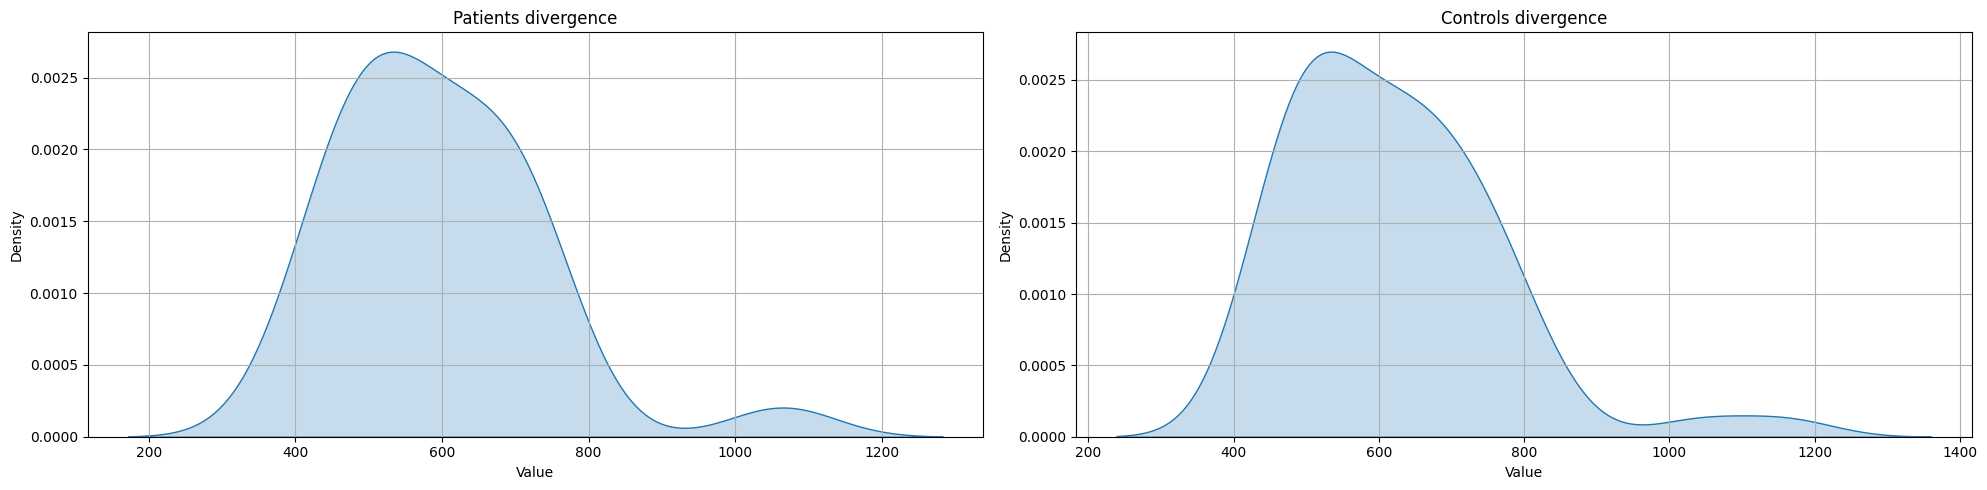

T-statistic: -0.7367975223782575
P-value: 0.4644284791092713
No statistically significant difference found (p >= 0.05).


In [26]:
column_div_patients = [sum_columnwise_divergence(np.where(np.abs(reference_matrix) > np.quantile(np.abs(reference_matrix), q=0), reference_matrix, 0), 
                                                 np.where(np.abs(patient_matrices['kl_divergence']) > np.quantile(np.abs(patient_matrices['kl_divergence']), q=0), patient_matrices['kl_divergence'], 0)
                                                 ) for patient_matrices in (patients_connectomes).values()]
column_div_controls = [sum_columnwise_divergence(np.where(np.abs(reference_matrix) > np.quantile(np.abs(reference_matrix), q=0), reference_matrix, 0), 
                                                 np.where(np.abs(patient_matrices['kl_divergence']) > np.quantile(np.abs(patient_matrices['kl_divergence']), q=0), patient_matrices['kl_divergence'], 0)
                                                 ) for patient_matrices in (controls_connectomes).values()]
plot_density(column_div_patients, column_div_controls, titles=["Patients divergence", "Controls divergence"])
_,_ = do_t_test(column_div_patients, column_div_controls)

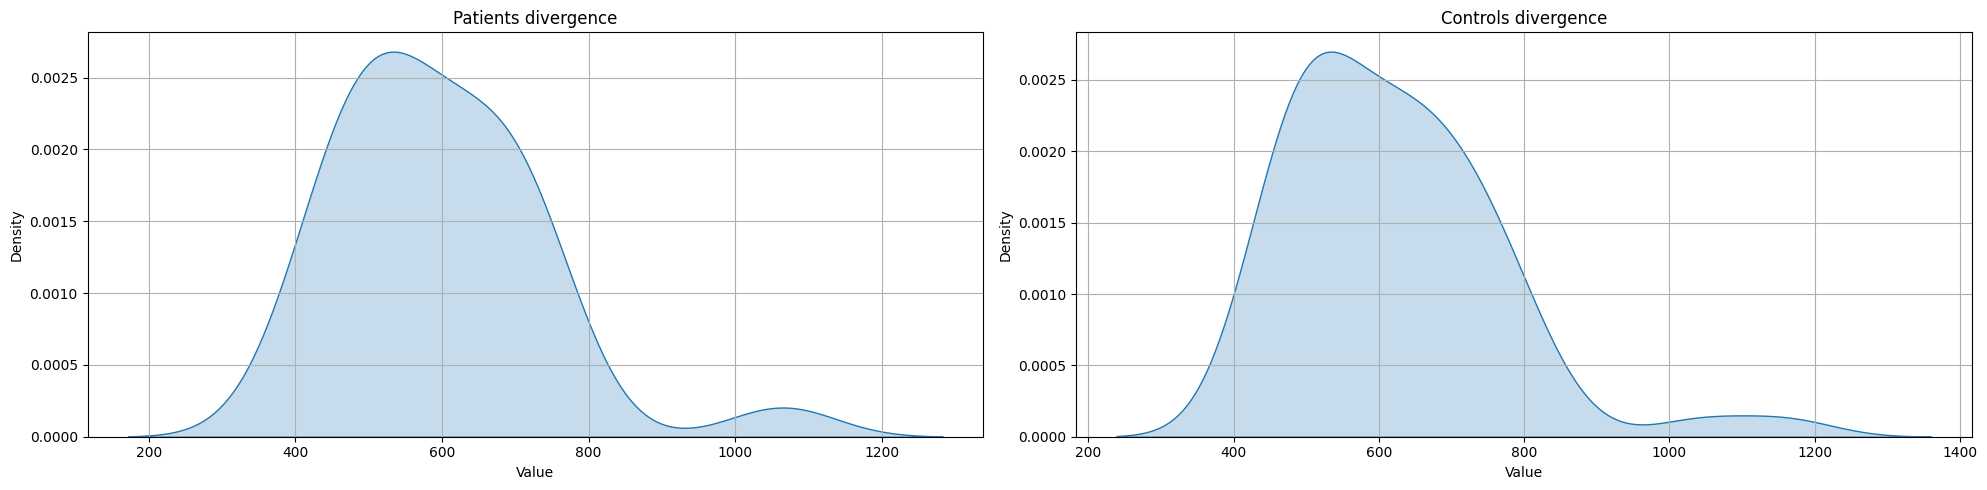

T-statistic: -0.7367975223782575
P-value: 0.4644284791092713
No statistically significant difference found (p >= 0.05).


In [27]:
#ref_res = np.mean(distance_to_ref_patients, axis=0)
ref_res = np.zeros(shape=distance_to_ref_patients[0].shape)

column_div_res_patients = [sum_columnwise_divergence(np.where(np.abs(ref_res) > np.quantile(np.abs(ref_res), q=0), ref_res, 0), 
                                                 np.where(np.abs(patient_matrices) > np.quantile(np.abs(patient_matrices), q=0), patient_matrices, 0)
                                                 ) for patient_matrices in distance_to_ref_patients]
column_div_res_controls = [sum_columnwise_divergence(np.where(np.abs(ref_res) > np.quantile(np.abs(ref_res), q=0), ref_res, 0), 
                                                 np.where(np.abs(patient_matrices) > np.quantile(np.abs(patient_matrices), q=0), patient_matrices, 0)
                                                 ) for patient_matrices in distance_to_ref_controls]
plot_density(column_div_patients, column_div_controls, titles=["Patients divergence", "Controls divergence"])
_,_ = do_t_test(column_div_patients, column_div_controls)

Now, we will mess up.

In [ ]:
import numpy as np
import random

import tensorflow as tf
from tensorflow.keras import layers 

import matplotlib.pyplot as plt

from VAE import *

num_spirals = 2
num_points = len(combined_connectomes)

# Generate a 5-dimensional spiral dataset
dimensions = 128
features = 128

batch_size = 16
epochs = 20
latent_dim = 150
num_examples_to_generate = 4

max_training = None
max_testing = None

In [ ]:
def remove_last_n_elements_and_slice(dictionary, n):
    """
    Removes the last n elements from a dictionary (maintaining order) and returns both the new dictionary and the removed slice.

    Args:
        dictionary: The input dictionary.
        n: The number of elements to remove from the end.

    Returns:
        A tuple containing:
            - A new dictionary with the last n elements removed.
            - A dictionary containing the removed slice.
    """

    def shuffle_dictionary(dictionary):
        """
        Shuffles a dictionary and returns a new shuffled dictionary.

        Args:
            dictionary: The input dictionary.

        Returns:
            A new dictionary with the same key-value pairs but in a shuffled order.
        """
        if not isinstance(dictionary, dict):
            raise TypeError("Input must be a dictionary.")

        items = list(dictionary.items())  # Get key-value pairs as a list of tuples
        random.shuffle(items)  # Shuffle the list of tuples
        return dict(items)  # Create a new dictionary from the shuffled list

    if not isinstance(dictionary, dict):
        raise TypeError("Input must be a dictionary.")

    if not isinstance(n, int) or n < 0:
        raise ValueError("n must be a non-negative integer.")

    if not dictionary:  # Handle empty dictionary
        return {}, {}

    if n >= len(dictionary):
        return {}, dictionary.copy()
    
    dictionary = shuffle_dictionary(dictionary)
    items = list(dictionary.items())
    new_items = items[:-n]
    removed_items = items[-n:]

    return dict(new_items), dict(removed_items)

In [51]:
x_train_t, x_test_t = remove_last_n_elements_and_slice(combined_connectomes, 10)
x_train = np.array([patient_matrices['kl_divergence'] for patient_matrices in (x_train_t).values()])
x_test = np.array([patient_matrices['kl_divergence'] for patient_matrices in (x_test_t).values()])
y_train = np.array([0 if patient in patients_connectomes else 1 for patient in (x_train_t).keys()])
y_test = np.array([0 if patient in patients_connectomes else 1 for patient in (x_test_t).keys()])
del x_train_t, x_test_t
print(x_train, y_train, x_test, y_test)
print("Data shape:", x_train.shape)  # Should be (n_samples, length, n_features)
print("Labels shape:", y_train.shape)  # Should be (n_samples,)


[[[0.00000000e+00 7.58096100e-01 3.67647258e-01 ... 1.85298962e-01
   1.29629658e-01 1.83178719e-02]
  [7.58096100e-01 0.00000000e+00 8.03665884e-01 ... 1.74455661e-01
   1.42976129e-02 7.42781549e-04]
  [3.67647258e-01 8.03665884e-01 0.00000000e+00 ... 2.74068497e-02
   1.29933528e-04 3.48294187e-07]
  ...
  [1.85298962e-01 1.74455661e-01 2.74068497e-02 ... 0.00000000e+00
   1.07454702e-01 5.46470502e-02]
  [1.29629658e-01 1.42976129e-02 1.29933528e-04 ... 1.07454702e-01
   0.00000000e+00 8.34861232e-01]
  [1.83178719e-02 7.42781549e-04 3.48294187e-07 ... 5.46470502e-02
   8.34861232e-01 0.00000000e+00]]

 [[0.00000000e+00 8.10025771e-01 2.35756352e-01 ... 1.02859665e-03
   9.38014502e-01 6.87229685e-01]
  [8.10025771e-01 0.00000000e+00 5.62996017e-01 ... 1.31070388e-02
   9.48436501e-01 2.71405545e-01]
  [2.35756352e-01 5.62996017e-01 0.00000000e+00 ... 2.71896256e-03
   3.65189078e-01 1.69704188e-02]
  ...
  [1.02859665e-03 1.31070388e-02 2.71896256e-03 ... 0.00000000e+00
   6.19720

In [ ]:
train_dataset, test_dataset, train_size, test_size = build_tf_dataset(x_train, x_train, batch_size, max_training, max_testing, True)

### Experiment B: Let's go back to the standard approach and try to see what we can do